In [ ]:
!pip install openai

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the base directory where your data is stored
base_dir = '/content/drive/MyDrive/IBY_TASK/'

# Base directories where the data is stored
transcripts_base_dir = '/content/drive/MyDrive/IBY_TASK/transcripts'
transcript_scores_dir = '/content/drive/MyDrive/IBY_TASK/transcript_data'
emotion_data_base_dir = '/content/drive/MyDrive/IBY_TASK/emotion_data'


In [ ]:
# List of folders (each representing a candidate)
folders = [str(i) for i in range(1, 11)]  # Folders named '1' to '10'

# Initialize empty lists to store data
all_emotion_data = []
all_gaze_data = []
all_metadata = []

# Loop through each folder and load the data
for folder in folders:
    folder_path = os.path.join(emotion_data_base_dir, folder)

    # Load emotion.csv
    emotion_file = os.path.join(folder_path, 'emotion.csv')
    emotion_df = pd.read_csv(emotion_file)
    emotion_df['candidate_id'] = folder  # Add a column to identify the candidate
    all_emotion_data.append(emotion_df)

    # Load gaze.csv
    gaze_file = os.path.join(folder_path, 'gaze.csv')
    gaze_df = pd.read_csv(gaze_file)
    gaze_df['candidate_id'] = folder  # Add a column to identify the candidate
    all_gaze_data.append(gaze_df)

    # Load metadata.csv
    metadata_file = os.path.join(folder_path, 'metadata.csv')
    metadata_df = pd.read_csv(metadata_file)
    metadata_df['candidate_id'] = folder  # Add a column to identify the candidate
    all_metadata.append(metadata_df)

# Combine all data into single DataFrames
combined_emotion_data = pd.concat(all_emotion_data, ignore_index=True)
combined_gaze_data = pd.concat(all_gaze_data, ignore_index=True)
combined_metadata = pd.concat(all_metadata, ignore_index=True)

# # Display the combined data
# print("Combined Emotion Data:")
# print(combined_emotion_data.head())

# print("\nCombined Gaze Data:")
# print(combined_gaze_data.head())

# print("\nCombined Metadata:")
# print(combined_metadata.head())

# iterating the columns
print("Emotion Data Columns:")
print(combined_emotion_data.columns)

print("\nGaze Data Columns:")
print(combined_gaze_data.columns)

print("\nMetadata Columns:")
print(combined_metadata.columns)


# Counting number of rows per candidate for each dataset
rows_per_candidate_emotion = combined_emotion_data['candidate_id'].value_counts()
rows_per_candidate_gaze = combined_gaze_data['candidate_id'].value_counts()
rows_per_candidate_metadata = combined_metadata['candidate_id'].value_counts()

# Combine into a summary DataFrame
row_summary = pd.DataFrame({
    'Emotion Rows': rows_per_candidate_emotion,
    'Gaze Rows': rows_per_candidate_gaze,
    'Metadata Rows': rows_per_candidate_metadata
}).fillna(0).astype(int)  # Fill any missing entries with 0

# Display the summary
print(row_summary)



Emotion Data Columns:
Index(['movie_id', 'image_seq', 'angry', 'disgust', 'fear', 'happy', 'sad',
       'surprise', 'neutral', 'dominant_emotion', 'candidate_id'],
      dtype='object')

Gaze Data Columns:
Index(['movie_id', 'image_seq', 'gaze', 'blink', 'eye_offset', 'candidate_id'], dtype='object')

Metadata Columns:
Index(['movie_id', 'image_seq', 'participant_id', 'elapsed_time',
       'upload_time', 'distance', 'candidate_id'],
      dtype='object')
              Emotion Rows  Gaze Rows  Metadata Rows
candidate_id                                        
1                       87         88             30
10                      90         90             91
2                       87         87             87
3                      100        100            100
4                       99         99             99
5                        4          4              4
6                       14         14             14
7                       87         87             51
8        

In [ ]:
# Merge emotion data with gaze data, keeping all rows
merged_data = pd.merge(combined_emotion_data, combined_gaze_data,
                       on=['movie_id', 'image_seq', 'candidate_id'],
                       how='outer')

# Merge the above result with metadata, keeping all rows
final_merged_data = pd.merge(merged_data, combined_metadata,
                             on=['movie_id', 'image_seq', 'candidate_id'],
                             how='outer')

# Display the final merged data
print(final_merged_data.head())


                               movie_id  image_seq     angry   disgust  \
0  93663f94-bf0a-4ce8-a29a-a5236cc7fe6a          0   4.31735  0.000594   
1  93663f94-bf0a-4ce8-a29a-a5236cc7fe6a          1  53.22530  2.981640   
2  93663f94-bf0a-4ce8-a29a-a5236cc7fe6a          2   8.79651  0.029468   
3  93663f94-bf0a-4ce8-a29a-a5236cc7fe6a          3   9.45303  0.106778   
4  93663f94-bf0a-4ce8-a29a-a5236cc7fe6a          4  56.00020  0.000004   

        fear     happy        sad   surprise   neutral dominant_emotion  \
0   2.879790   1.65035   2.779980   0.600814  87.77110          neutral   
1  12.736800   1.52347   1.051320  27.216800   1.26462            angry   
2   2.968160  16.83150  39.884600   0.279335  31.21050              sad   
3   1.553080  20.93010   3.503870   0.909426  63.54370          neutral   
4   0.162231   5.58358   0.197026  12.807600  25.24940            angry   

  candidate_id  gaze  blink  eye_offset participant_id  elapsed_time  \
0            1   NaN    NaN     

In [ ]:
# Count the number of rows per candidate in the final merged data
rows_per_candidate_final = final_merged_data['candidate_id'].value_counts()

# Display the count of rows per candidate
print("Number of rows per candidate in the final merged data:")
print(rows_per_candidate_final)

Number of rows per candidate in the final merged data:
candidate_id
3     101
4     100
1      96
8      94
10     92
2      88
7      88
9      87
6      15
5       5
Name: count, dtype: int64


In [ ]:
# Step 1: Ensure no duplicated columns
final_merged_data_cleaned = final_merged_data.loc[:, ~final_merged_data.columns.duplicated()]

# Drop any full duplicate rows based on the relevant columns (make sure there are no duplicates)
final_merged_data_cleaned = final_merged_data_cleaned.drop_duplicates(subset=['candidate_id', 'dominant_emotion', 'movie_id', 'image_seq'])

# Recalculate emotion percentage
# Perform groupby and calculate size, ensuring candidate_id issues are handled
emotion_percentage = (
    final_merged_data_cleaned.groupby(['candidate_id', 'dominant_emotion'])
    .size()
    .reset_index(name='count')  # Get counts for each dominant emotion per candidate
)

# Calculate percentage of each emotion for each candidate
emotion_percentage['percentage'] = emotion_percentage.groupby('candidate_id')['count'].transform(lambda x: 100 * x / x.sum())


<Figure size 1400x800 with 0 Axes>

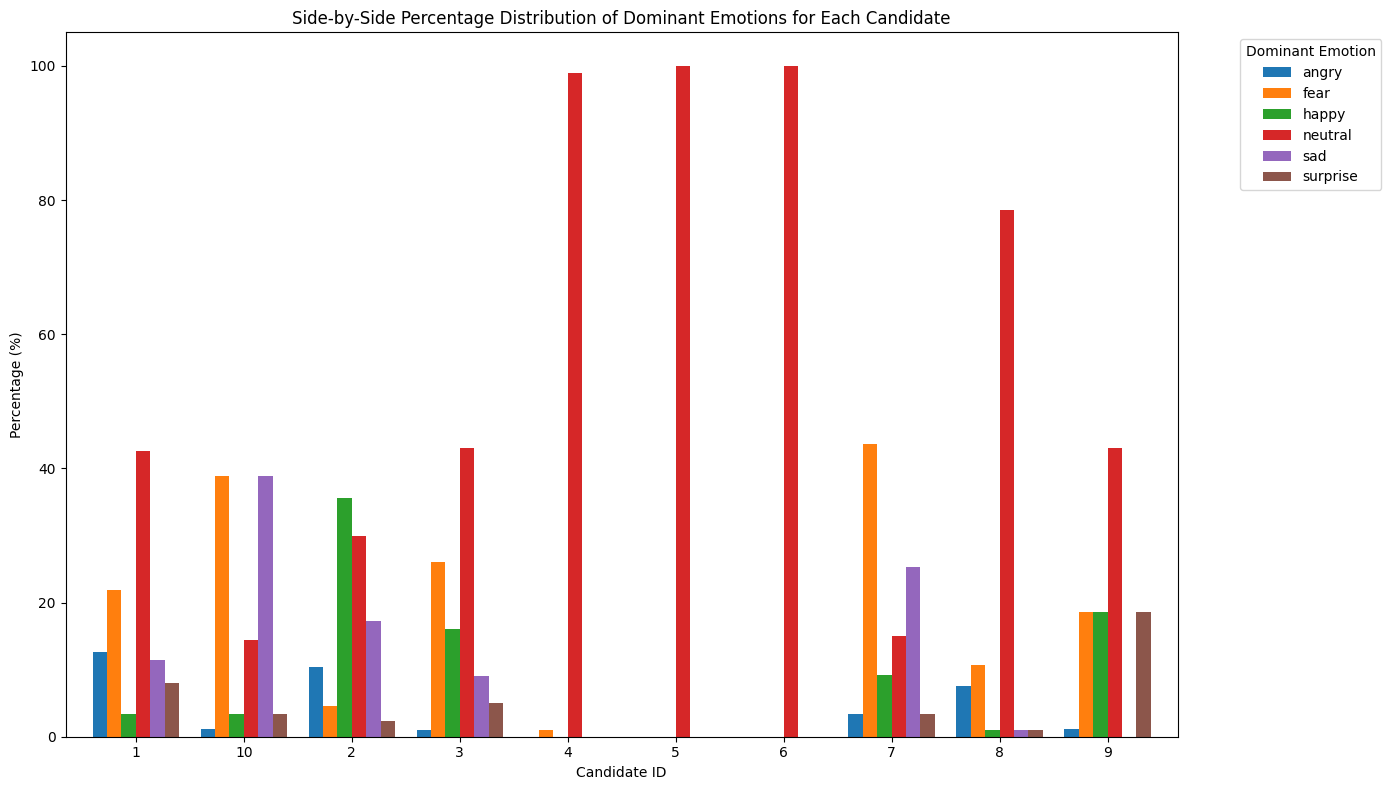

In [ ]:
# Unstack the pivot_data for side-by-side bars
pivot_data_unstacked = emotion_percentage.pivot(index='candidate_id', columns='dominant_emotion', values='percentage')

# Plot side-by-side bars for percentage distribution of dominant emotions
plt.figure(figsize=(14, 8))
pivot_data_unstacked.plot(kind='bar', width=0.8, figsize=(14, 8))
plt.title('Side-by-Side Percentage Distribution of Dominant Emotions for Each Candidate')
plt.xlabel('Candidate ID')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)  # Keep x-ticks horizontal for readability
plt.legend(title='Dominant Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-156-6e26cefbb931>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_percentage.index, y=emotion_percentage.values, palette="Blues_d")


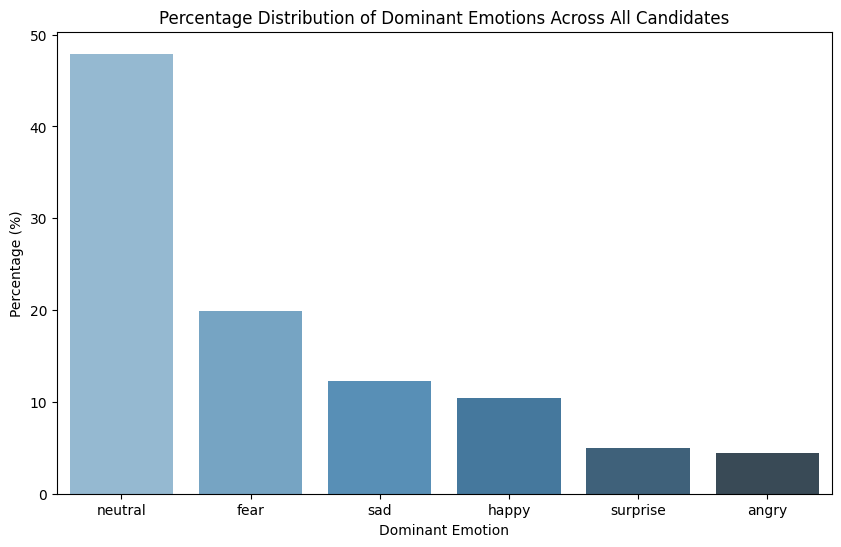

In [ ]:
# Calculate the percentage of each dominant emotion
emotion_counts = final_merged_data_cleaned['dominant_emotion'].value_counts()
emotion_percentage = (emotion_counts / emotion_counts.sum()) * 100

# Plot the percentage of each dominant emotion
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_percentage.index, y=emotion_percentage.values, palette="Blues_d")
plt.title('Percentage Distribution of Dominant Emotions Across All Candidates')
plt.xlabel('Dominant Emotion')
plt.ylabel('Percentage (%)')
plt.show()

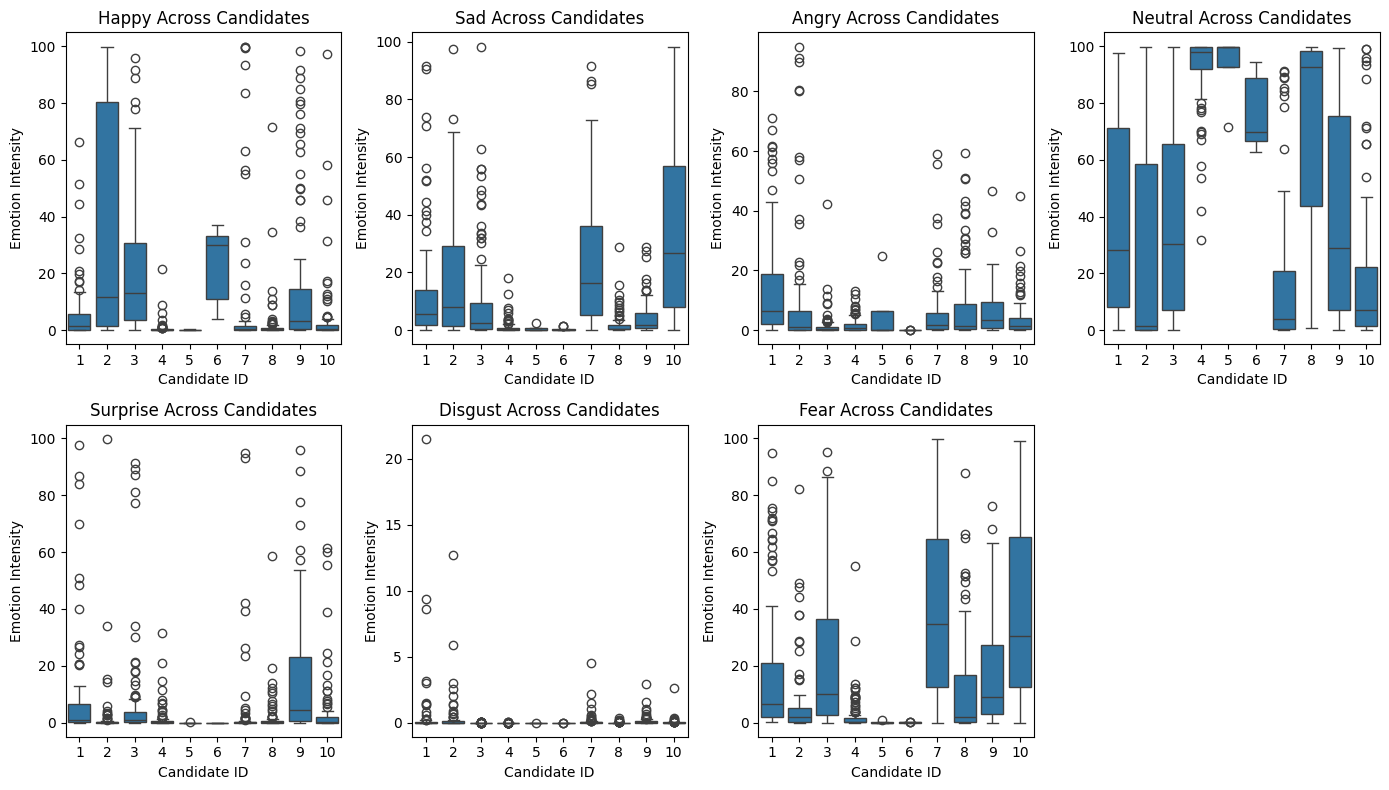

In [ ]:
plt.figure(figsize=(14, 8))
for i, emotion in enumerate(['happy', 'sad', 'angry', 'neutral', 'surprise', 'disgust', 'fear'], start=1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='candidate_id', y=emotion, data=final_merged_data)
    plt.title(f'{emotion.capitalize()} Across Candidates')
    plt.xlabel('Candidate ID')
    plt.ylabel('Emotion Intensity')
plt.tight_layout()
plt.show()


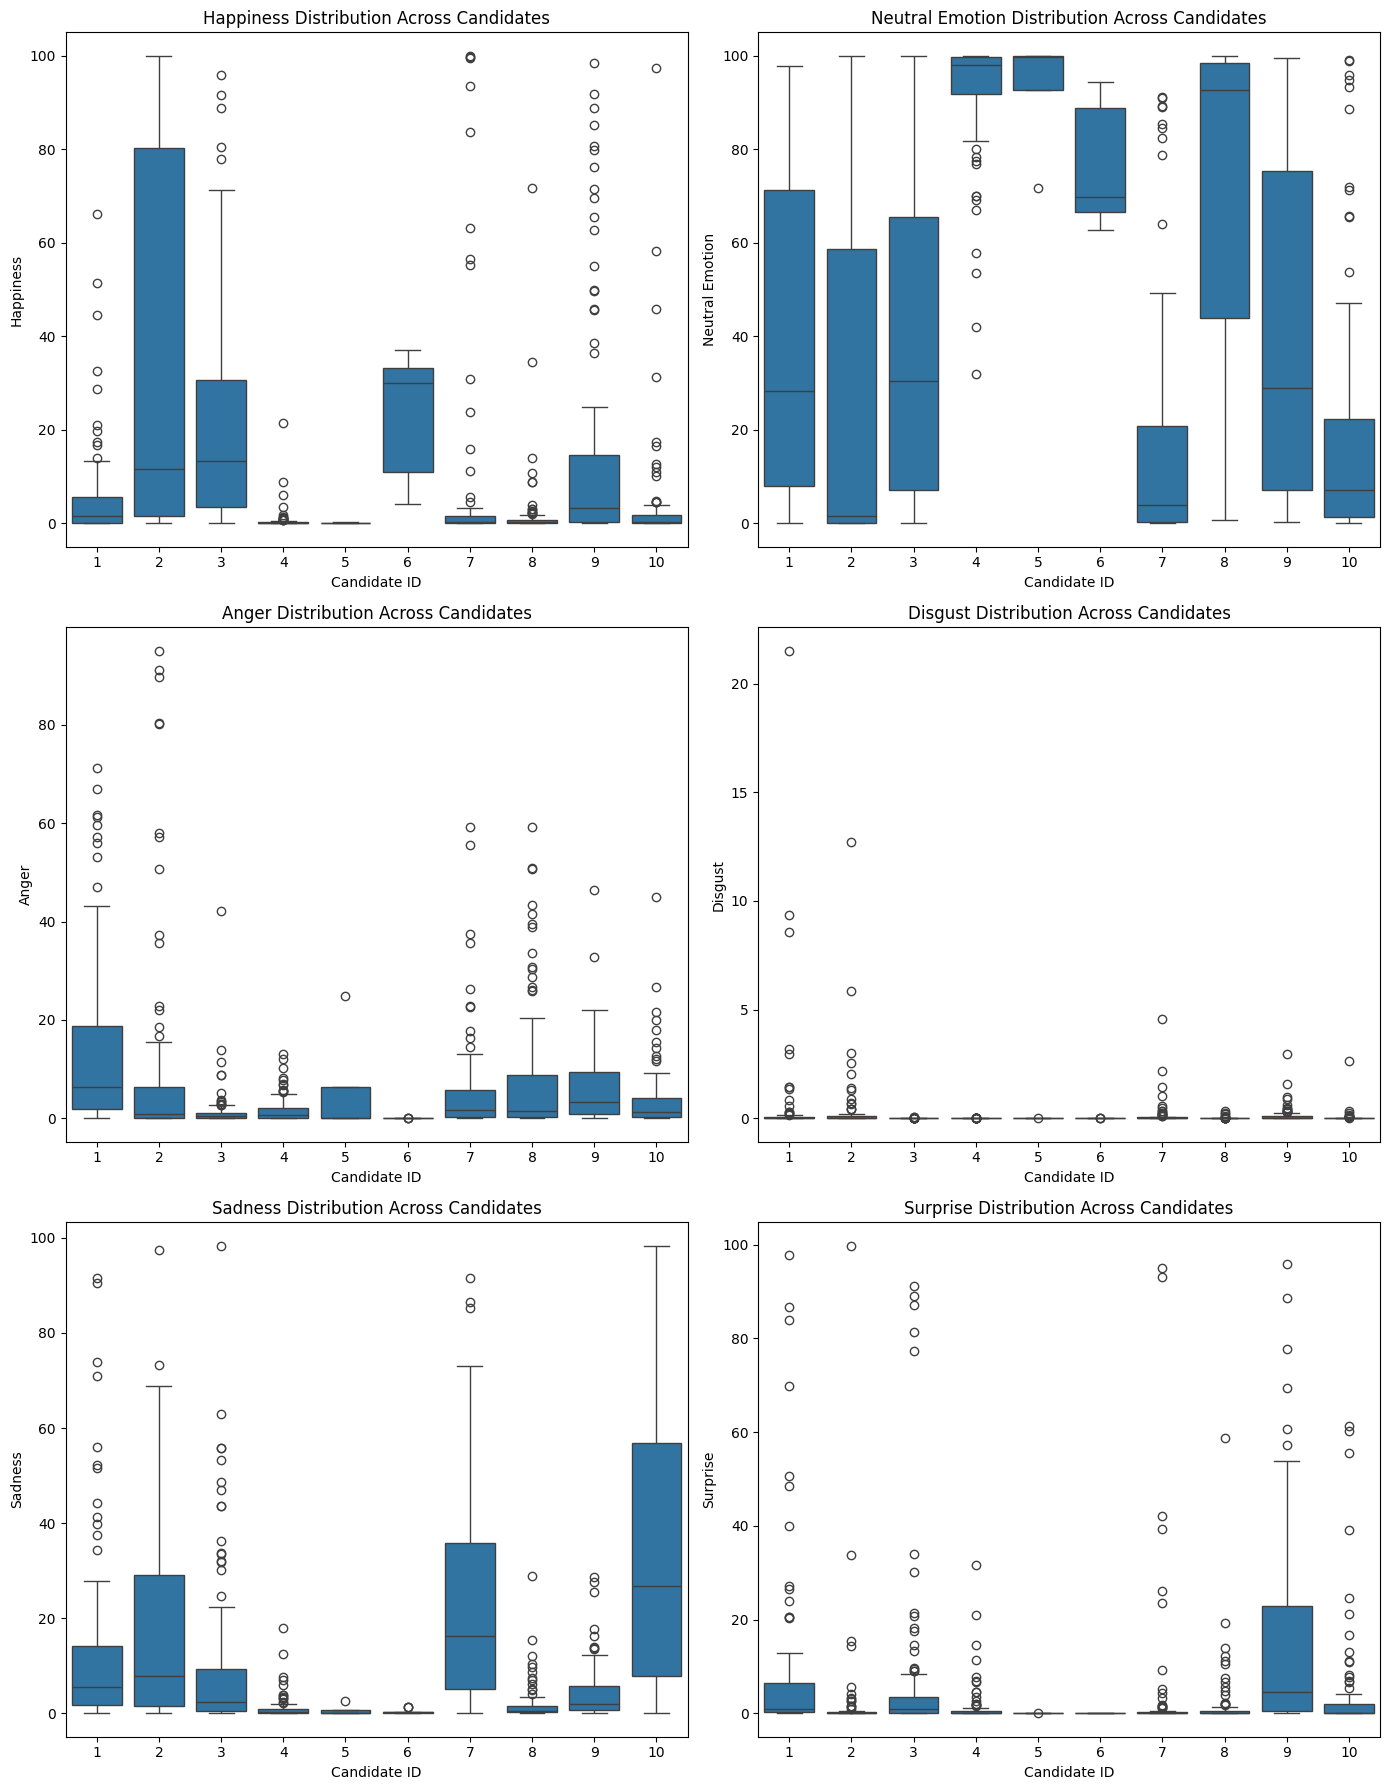

In [ ]:
plt.figure(figsize=(14, 18))  # Increase the height to fit all subplots

# Happiness
plt.subplot(3, 2, 1)
sns.boxplot(x='candidate_id', y='happy', data=combined_emotion_data)
plt.title('Happiness Distribution Across Candidates')
plt.xlabel('Candidate ID')
plt.ylabel('Happiness')

# Neutral Emotion
plt.subplot(3, 2, 2)
sns.boxplot(x='candidate_id', y='neutral', data=combined_emotion_data)
plt.title('Neutral Emotion Distribution Across Candidates')
plt.xlabel('Candidate ID')
plt.ylabel('Neutral Emotion')

# Angry Emotion
plt.subplot(3, 2, 3)
sns.boxplot(x='candidate_id', y='angry', data=combined_emotion_data)
plt.title('Anger Distribution Across Candidates')
plt.xlabel('Candidate ID')
plt.ylabel('Anger')

# Disgust Emotion
plt.subplot(3, 2, 4)
sns.boxplot(x='candidate_id', y='disgust', data=combined_emotion_data)
plt.title('Disgust Distribution Across Candidates')
plt.xlabel('Candidate ID')
plt.ylabel('Disgust')

# Sad Emotion
plt.subplot(3, 2, 5)
sns.boxplot(x='candidate_id', y='sad', data=combined_emotion_data)
plt.title('Sadness Distribution Across Candidates')
plt.xlabel('Candidate ID')
plt.ylabel('Sadness')

# Surprise Emotion
plt.subplot(3, 2, 6)
sns.boxplot(x='candidate_id', y='surprise', data=combined_emotion_data)
plt.title('Surprise Distribution Across Candidates')
plt.xlabel('Candidate ID')
plt.ylabel('Surprise')

plt.tight_layout()
plt.show()


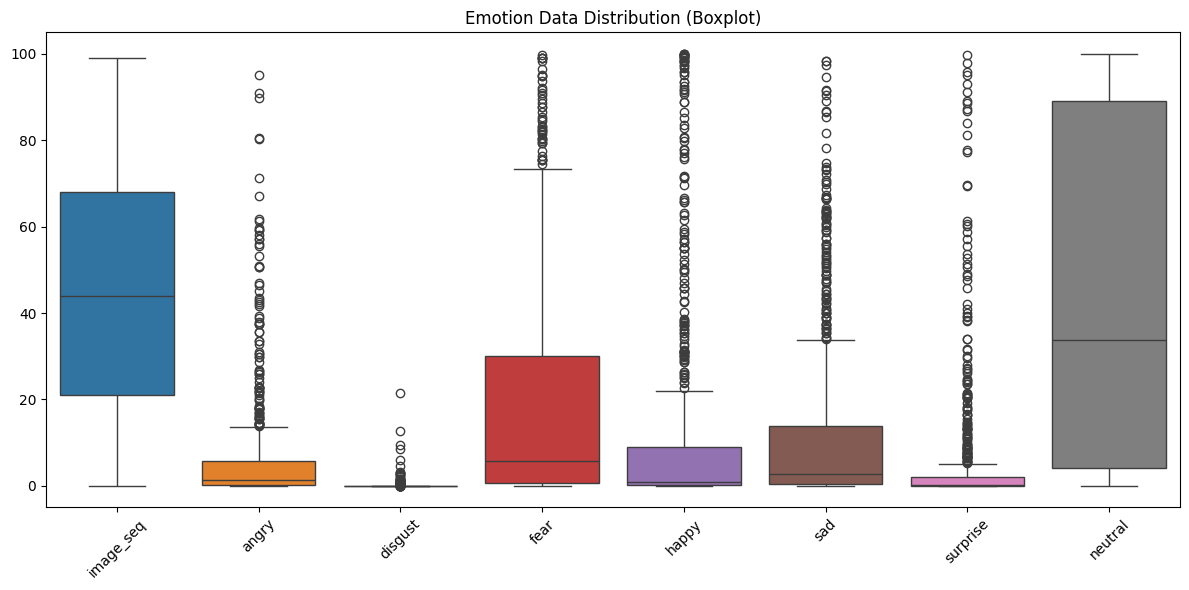

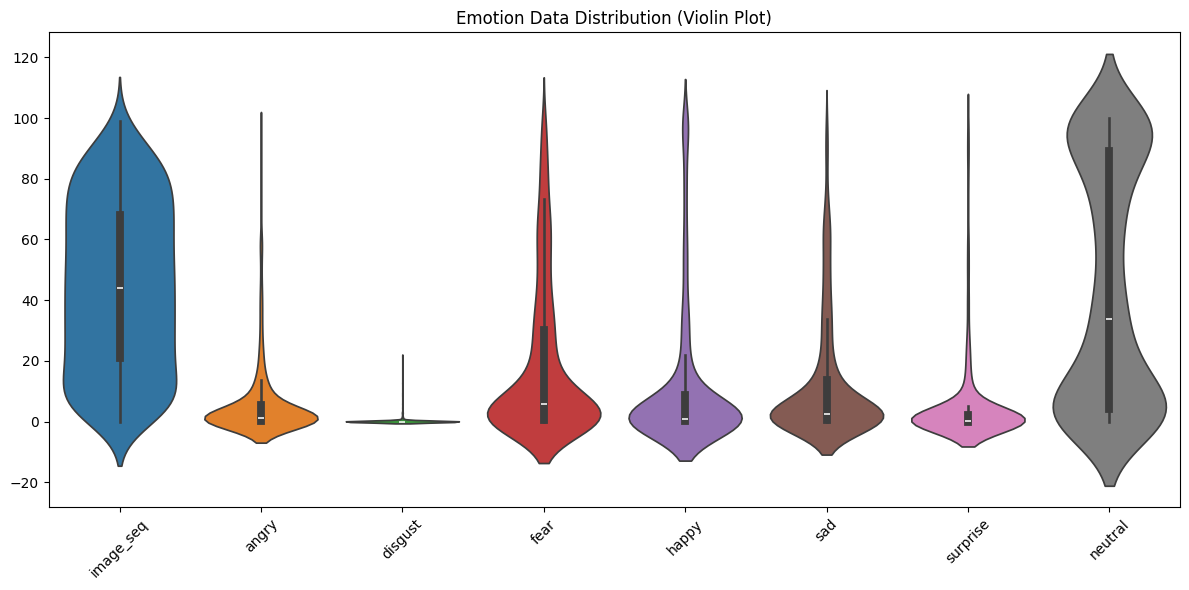

In [ ]:
# Visualizing the distribution of emotions using boxplots and violin plots
plt.figure(figsize=(12, 6))

# Boxplot for emotion data distribution
sns.boxplot(data=combined_emotion_data.drop(columns=['candidate_id']))
plt.title('Emotion Data Distribution (Boxplot)')
plt.xticks(rotation=45)
plt.tight_layout()

# Violin plot for emotion data distribution
plt.figure(figsize=(12, 6))
sns.violinplot(data=combined_emotion_data.drop(columns=['candidate_id']))
plt.title('Emotion Data Distribution (Violin Plot)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [ ]:
# Define a list to store data from all candidates for combined analysis
all_candidate_transcript_data = []

# Iterate through each candidate's data
for candidate_number in range(1, 11):
    # Load the transcript scores data
    transcript_score_file = os.path.join(transcript_scores_dir, f'{candidate_number}.csv')
    transcript_data = pd.read_csv(transcript_score_file)

    # Add a candidate_id column to the data
    transcript_data['candidate_id'] = candidate_number

    # Append this candidate's data to the list
    all_candidate_transcript_data.append(transcript_data)

combined_transcript_data = pd.concat(all_candidate_transcript_data, ignore_index=True)

print(transcript_data.columns)

Index(['id', 'seek', 'start', 'end', 'text', 'tokens', 'temperature',
       'avg_logprob', 'compression_ratio', 'no_speech_prob', 'positive',
       'negative', 'neutral', 'confident', 'hesitant', 'concise',
       'enthusiastic', 'speech_speed', 'candidate_id'],
      dtype='object')


In [ ]:
# # Pair plot (scatter plot matrix) for transcript data
# sns.pairplot(combined_transcript_data.drop(columns=['candidate_id']))
# plt.suptitle('Pair Plot of Transcript Data', y=1.02)
# plt.show()


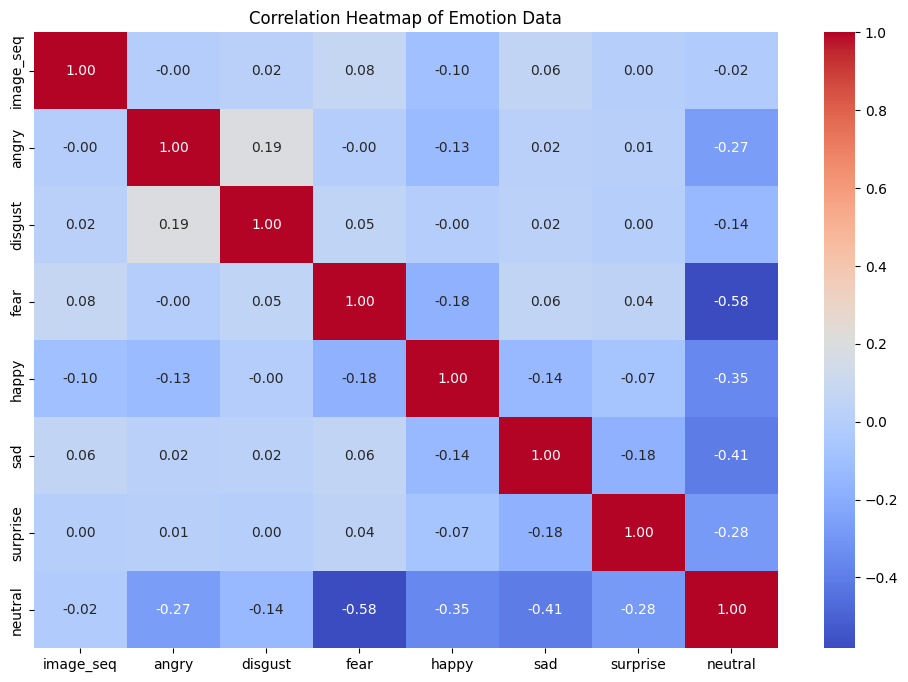

In [ ]:
# Ensure only numeric columns are used in the correlation matrix for emotion data
emotion_numeric_data = combined_emotion_data.select_dtypes(include=['float64', 'int64'])

# Plot the correlation heatmap for emotion data
plt.figure(figsize=(12, 8))
emotion_corr_matrix = emotion_numeric_data.corr()

sns.heatmap(emotion_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Emotion Data')
plt.show()


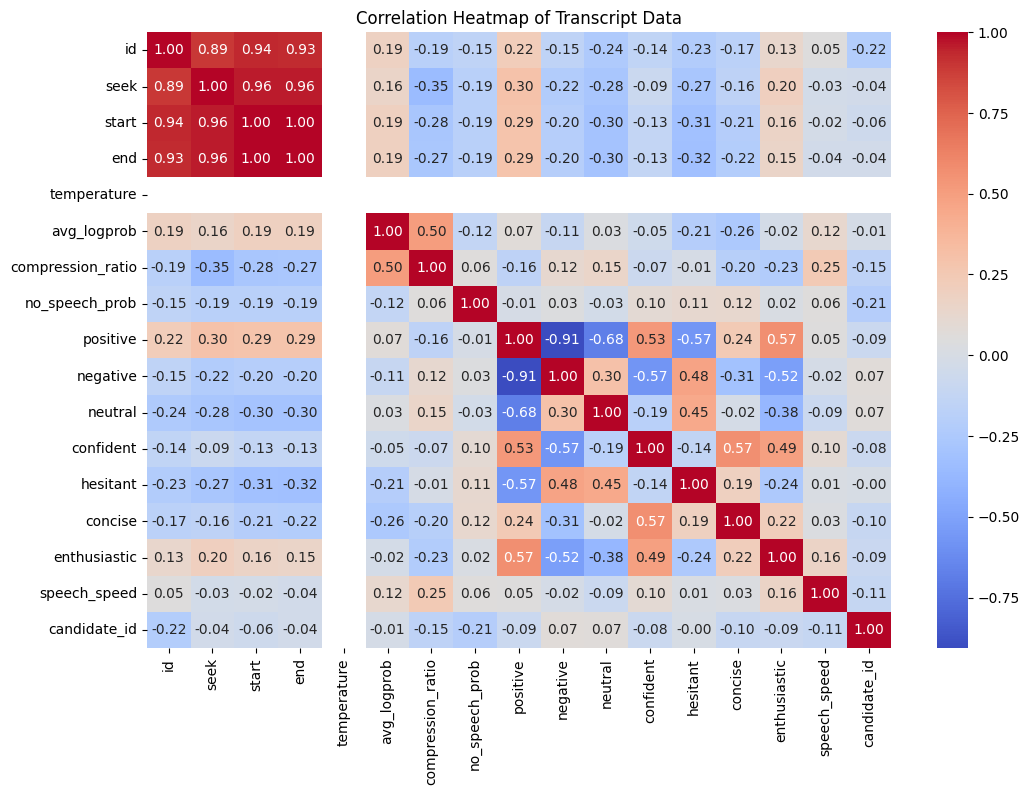

In [ ]:
# Ensure only numeric columns are used in the correlation matrix for transcript data
transcript_numeric_data = combined_transcript_data.select_dtypes(include=['float64', 'int64'])

# Plot the correlation heatmap for transcript data
plt.figure(figsize=(12, 8))
transcript_corr_matrix = transcript_numeric_data.corr()

sns.heatmap(transcript_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Transcript Data')
plt.show()


Multiple entries found for candidate 1. Aggregating data...


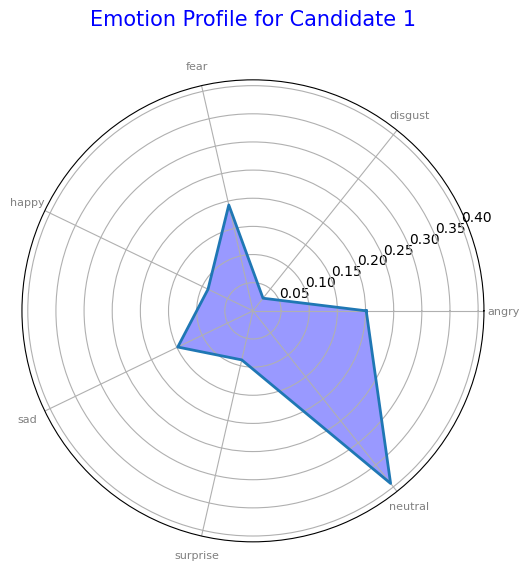

Multiple entries found for candidate 2. Aggregating data...


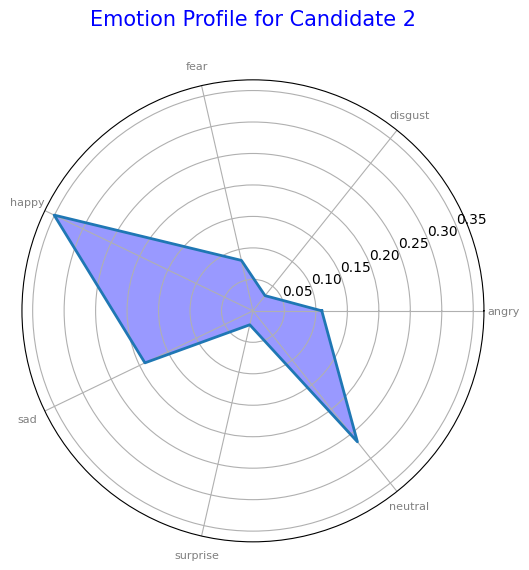

Multiple entries found for candidate 3. Aggregating data...


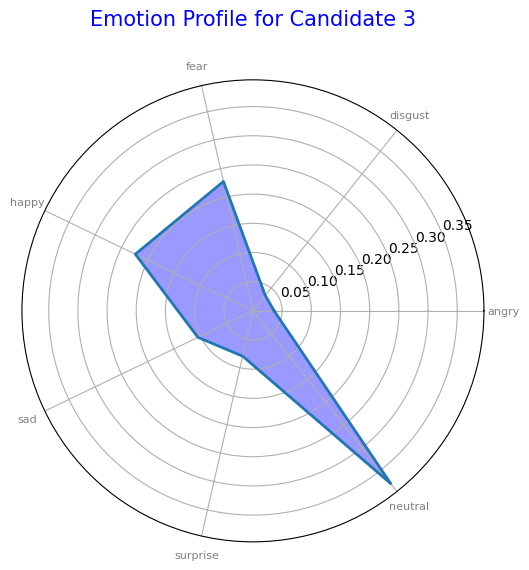

Multiple entries found for candidate 4. Aggregating data...


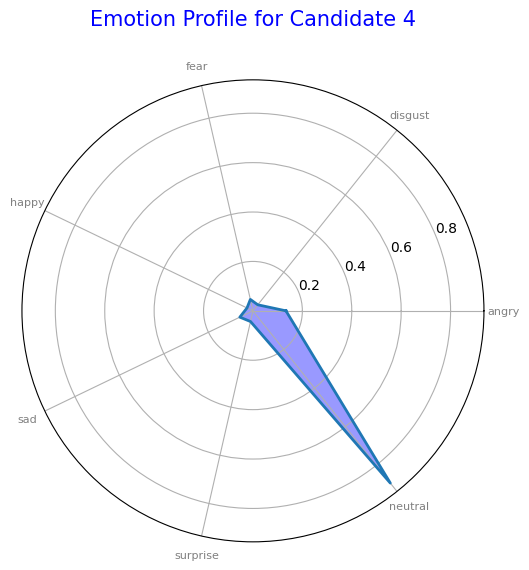

Multiple entries found for candidate 5. Aggregating data...


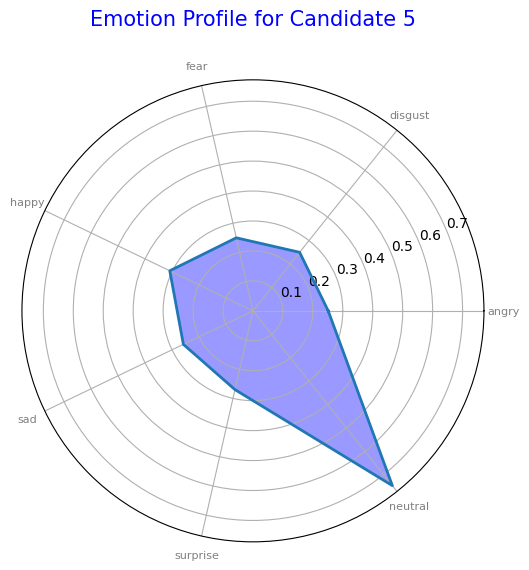

Multiple entries found for candidate 6. Aggregating data...


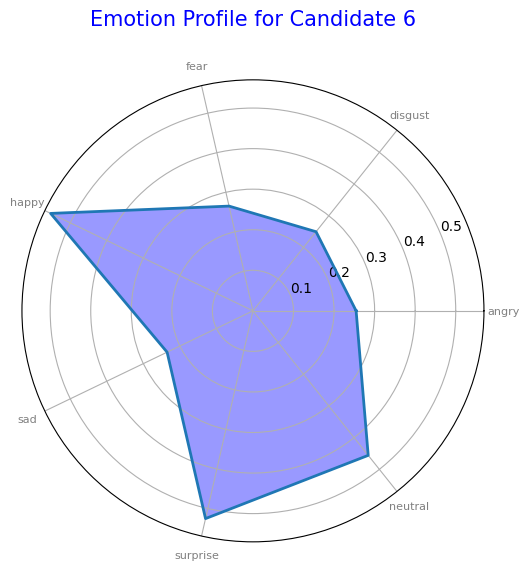

Multiple entries found for candidate 7. Aggregating data...


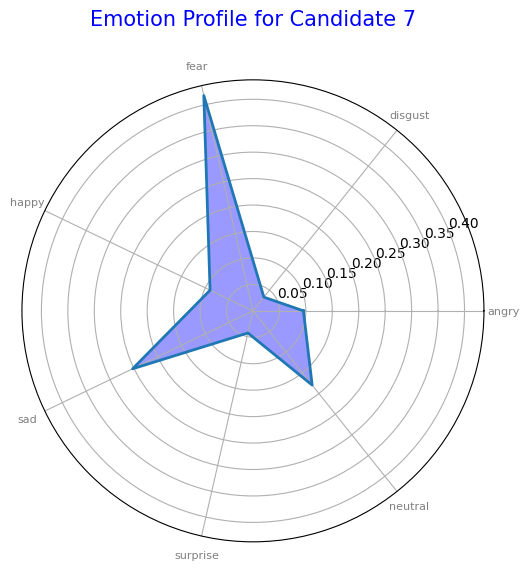

Multiple entries found for candidate 8. Aggregating data...


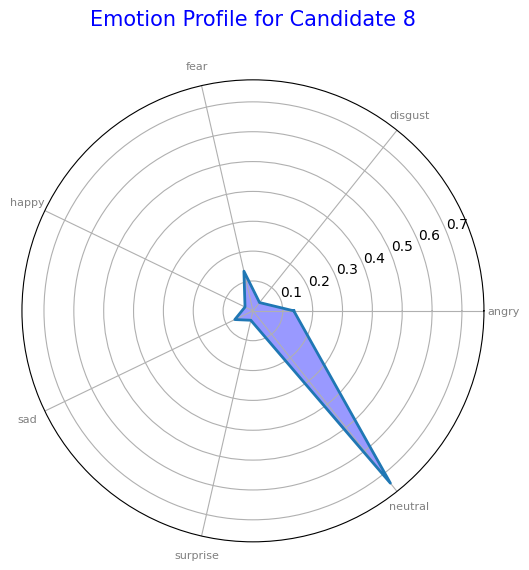

Multiple entries found for candidate 9. Aggregating data...


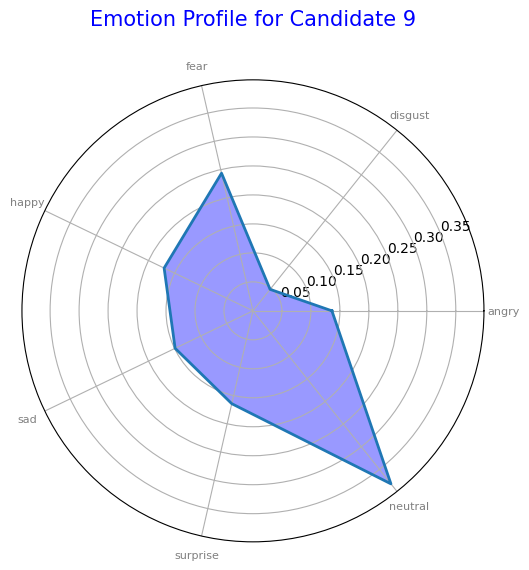

Multiple entries found for candidate 10. Aggregating data...


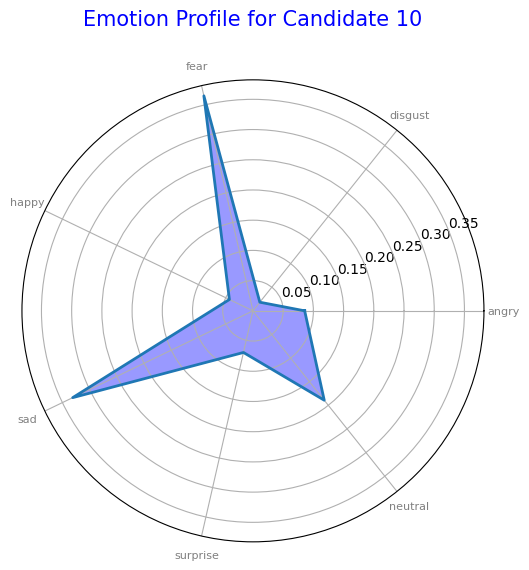

In [ ]:
from math import pi
from sklearn.preprocessing import MinMaxScaler

# Function to create radar chart for emotion data of a single candidate (excluding image_seq, with normalization)
def create_emotion_radar_chart(emotion_data, candidate_id):
    # Select the relevant data for the candidate
    candidate_data = emotion_data[emotion_data['candidate_id'] == str(candidate_id)]

    # Ensure the candidate exists
    if candidate_data.empty:
        print(f"No emotion data found for candidate {candidate_id}")
        return

    # Remove non-numeric columns and any specific unwanted columns (e.g., 'image_seq')
    candidate_data = candidate_data.select_dtypes(include=[float, int]).drop(columns=['image_seq'], errors='ignore')

    # Specify the columns to normalize (assuming they are numeric emotion-related features)
    columns_to_normalize = list(candidate_data.columns)

    # Apply normalization to the specified columns
    scaler = MinMaxScaler()
    candidate_data[columns_to_normalize] = scaler.fit_transform(candidate_data[columns_to_normalize])

    # Ensure there's only one row for the candidate (aggregate if necessary)
    if len(candidate_data) > 1:
        print(f"Multiple entries found for candidate {candidate_id}. Aggregating data...")
        candidate_data = candidate_data.mean()  # Aggregate using the mean
    else:
        candidate_data = candidate_data.iloc[0]  # Get the first row if only one entry exists

    # Get the emotion categories (the column names)
    categories = list(candidate_data.index)
    N = len(categories)

    # Get the values for the candidate
    values = candidate_data.values.flatten().tolist()

    # Ensure the number of values matches the number of categories
    if len(values) != N:
        print(f"Mismatch: {len(values)} values found, but {N} categories expected.")
        return

    values += values[:1]  # To close the radar chart
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Plot the radar chart
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.4)

    plt.title(f'Emotion Profile for Candidate {candidate_id}', size=15, color='blue', y=1.1)
    plt.show()

# Example usage for candidate 1
for i in range(1,11):
  create_emotion_radar_chart(combined_emotion_data, candidate_id=i)

Multiple entries found for candidate 1. Aggregating data...


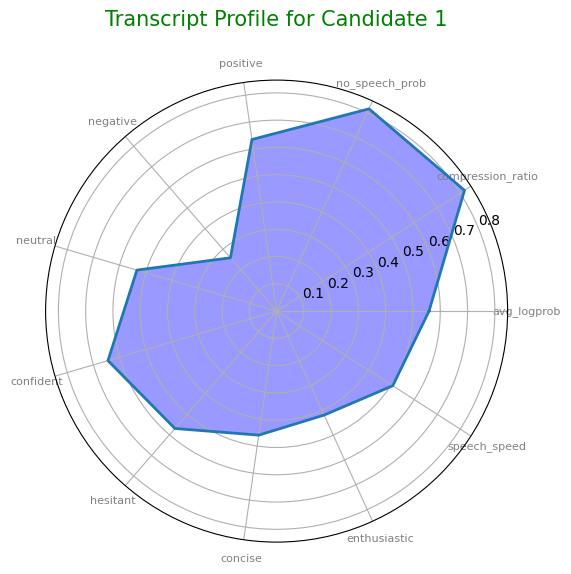

Multiple entries found for candidate 2. Aggregating data...


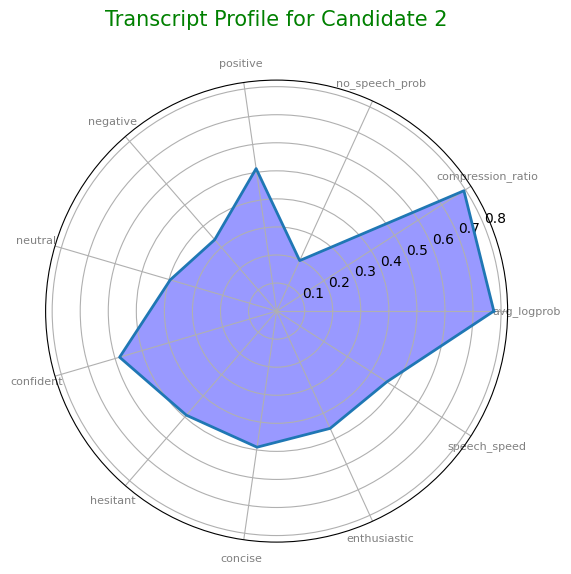

Multiple entries found for candidate 3. Aggregating data...


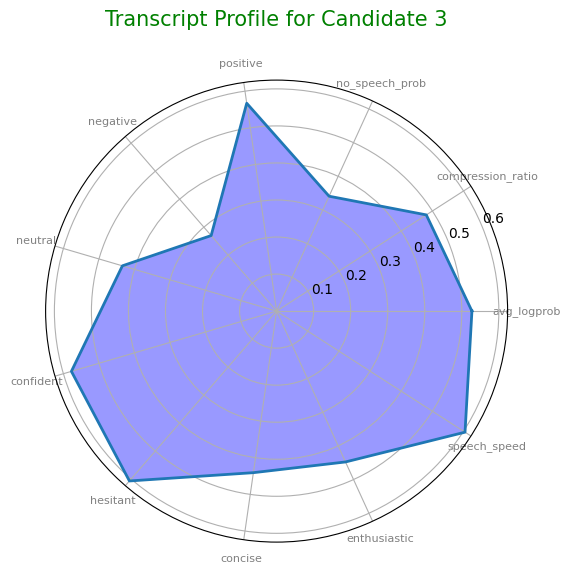

Multiple entries found for candidate 4. Aggregating data...


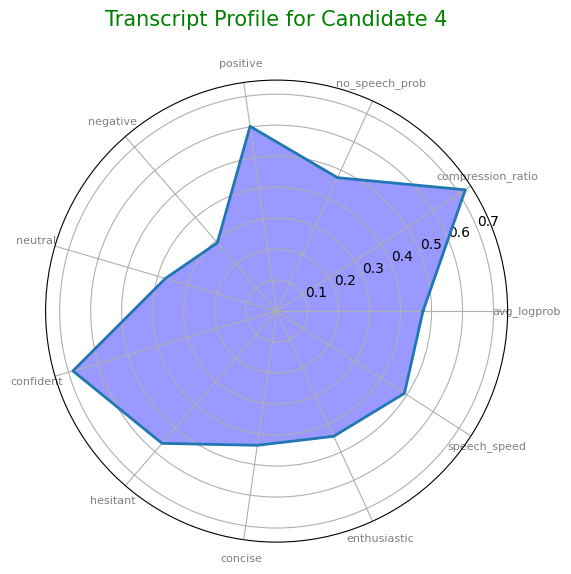

Multiple entries found for candidate 5. Aggregating data...


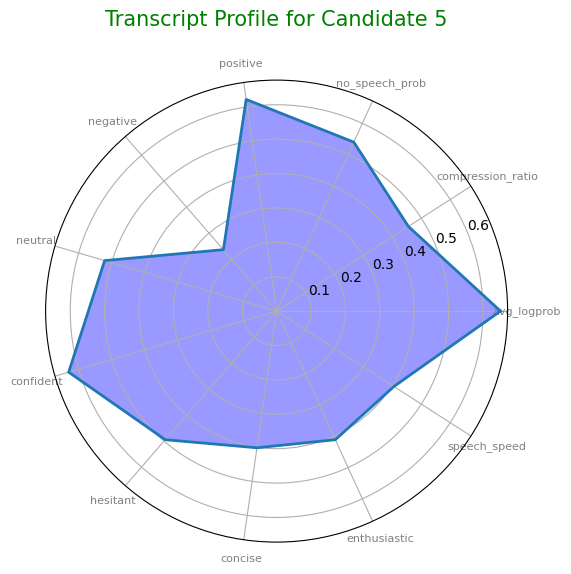

Multiple entries found for candidate 6. Aggregating data...


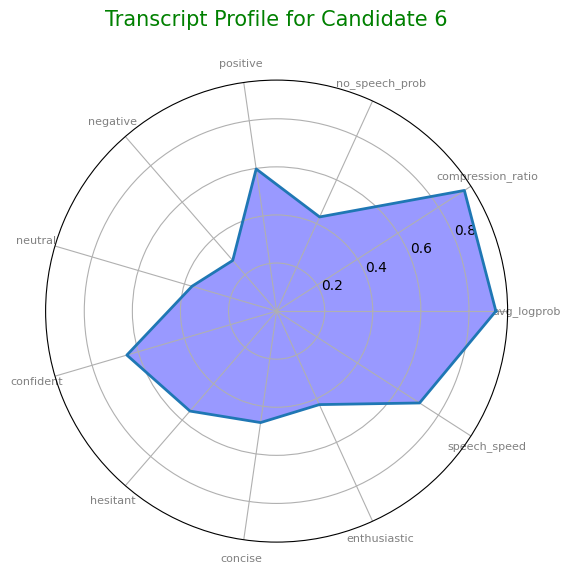

Multiple entries found for candidate 7. Aggregating data...


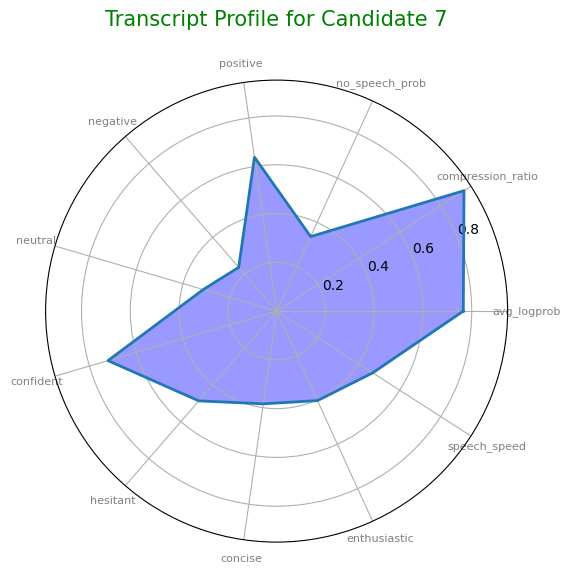

Multiple entries found for candidate 8. Aggregating data...


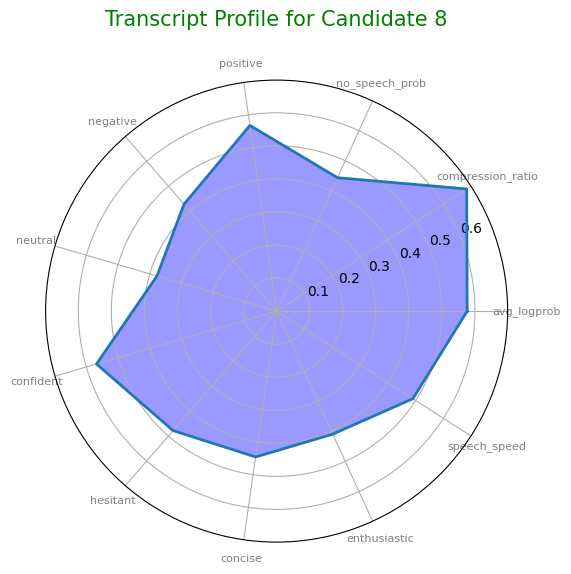

Multiple entries found for candidate 9. Aggregating data...


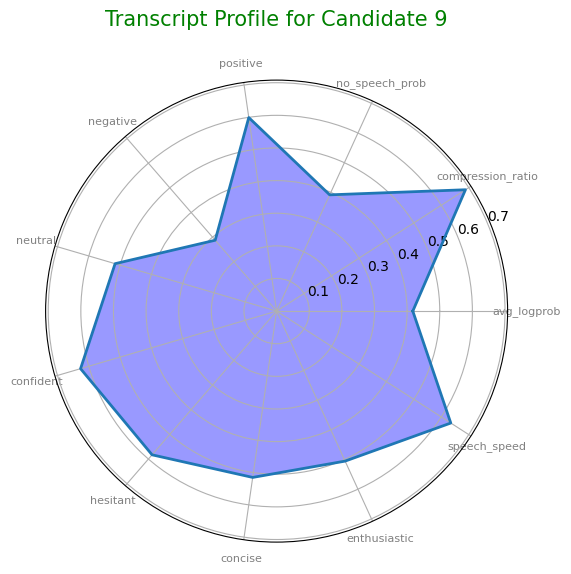

Multiple entries found for candidate 10. Aggregating data...


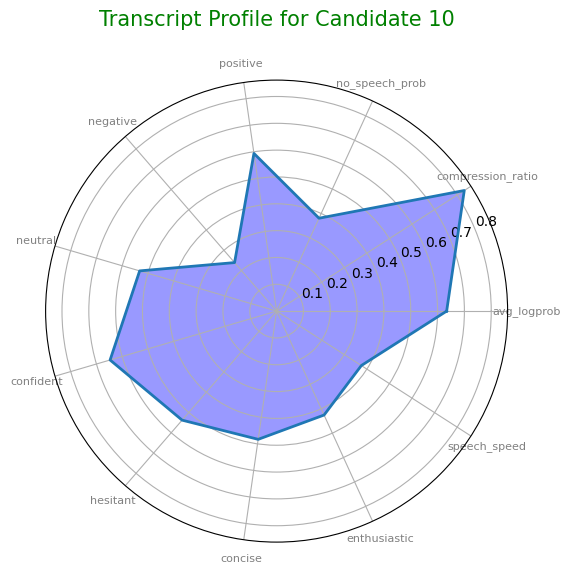

In [ ]:
# Function to create radar chart for transcript data of a single candidate (with column normalization)
def create_transcript_radar_chart(transcript_data, candidate_id):
    # Select the relevant data for the candidate
    candidate_data = transcript_data[transcript_data['candidate_id'] == int(candidate_id)]

    # Debugging: Check available candidate IDs
    if candidate_data.empty:
        print(f"No transcript data found for candidate {candidate_id}. Available IDs are: {transcript_data['candidate_id'].unique()}")
        return

    # Drop unwanted or non-numeric columns like 'id', 'start', 'end', 'seek', 'candidate_id', 'temperature', and 'transcript'
    columns_to_drop = ['id', 'start', 'end', 'seek', 'candidate_id', 'temperature', 'transcript']
    candidate_data = candidate_data.drop(columns=columns_to_drop, errors='ignore')

    # Specify the columns to normalize
    columns_to_normalize = [
        'avg_logprob', 'compression_ratio', 'no_speech_prob',
        'positive', 'negative', 'neutral', 'confident',
        'hesitant', 'concise', 'enthusiastic', 'speech_speed'
    ]

    # Apply normalization to the specified columns
    scaler = MinMaxScaler()
    candidate_data[columns_to_normalize] = scaler.fit_transform(candidate_data[columns_to_normalize])

    # Ensure there's only one row for the candidate (aggregate if necessary)
    if len(candidate_data) > 1:
        print(f"Multiple entries found for candidate {candidate_id}. Aggregating data...")
        candidate_data = candidate_data.select_dtypes(include=[float, int]).mean()  # Aggregate using the mean
    else:
        candidate_data = candidate_data.select_dtypes(include=[float, int]).iloc[0]  # Get the first row if only one entry exists

    # Get the transcript categories (the column names)
    categories = list(candidate_data.index)
    N = len(categories)

    # Get the values for the candidate
    values = candidate_data.values.flatten().tolist()

    # Ensure the number of values matches the number of categories
    if len(values) != N:
        print(f"Mismatch: {len(values)} values found, but {N} categories expected.")
        return

    values += values[:1]  # To close the radar chart
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Plot the radar chart
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.4)

    plt.title(f'Transcript Profile for Candidate {candidate_id}', size=15, color='green', y=1.1)
    plt.show()

# Example usage for candidate 1
for i in range(1,11):
  create_transcript_radar_chart(combined_transcript_data, candidate_id=i)



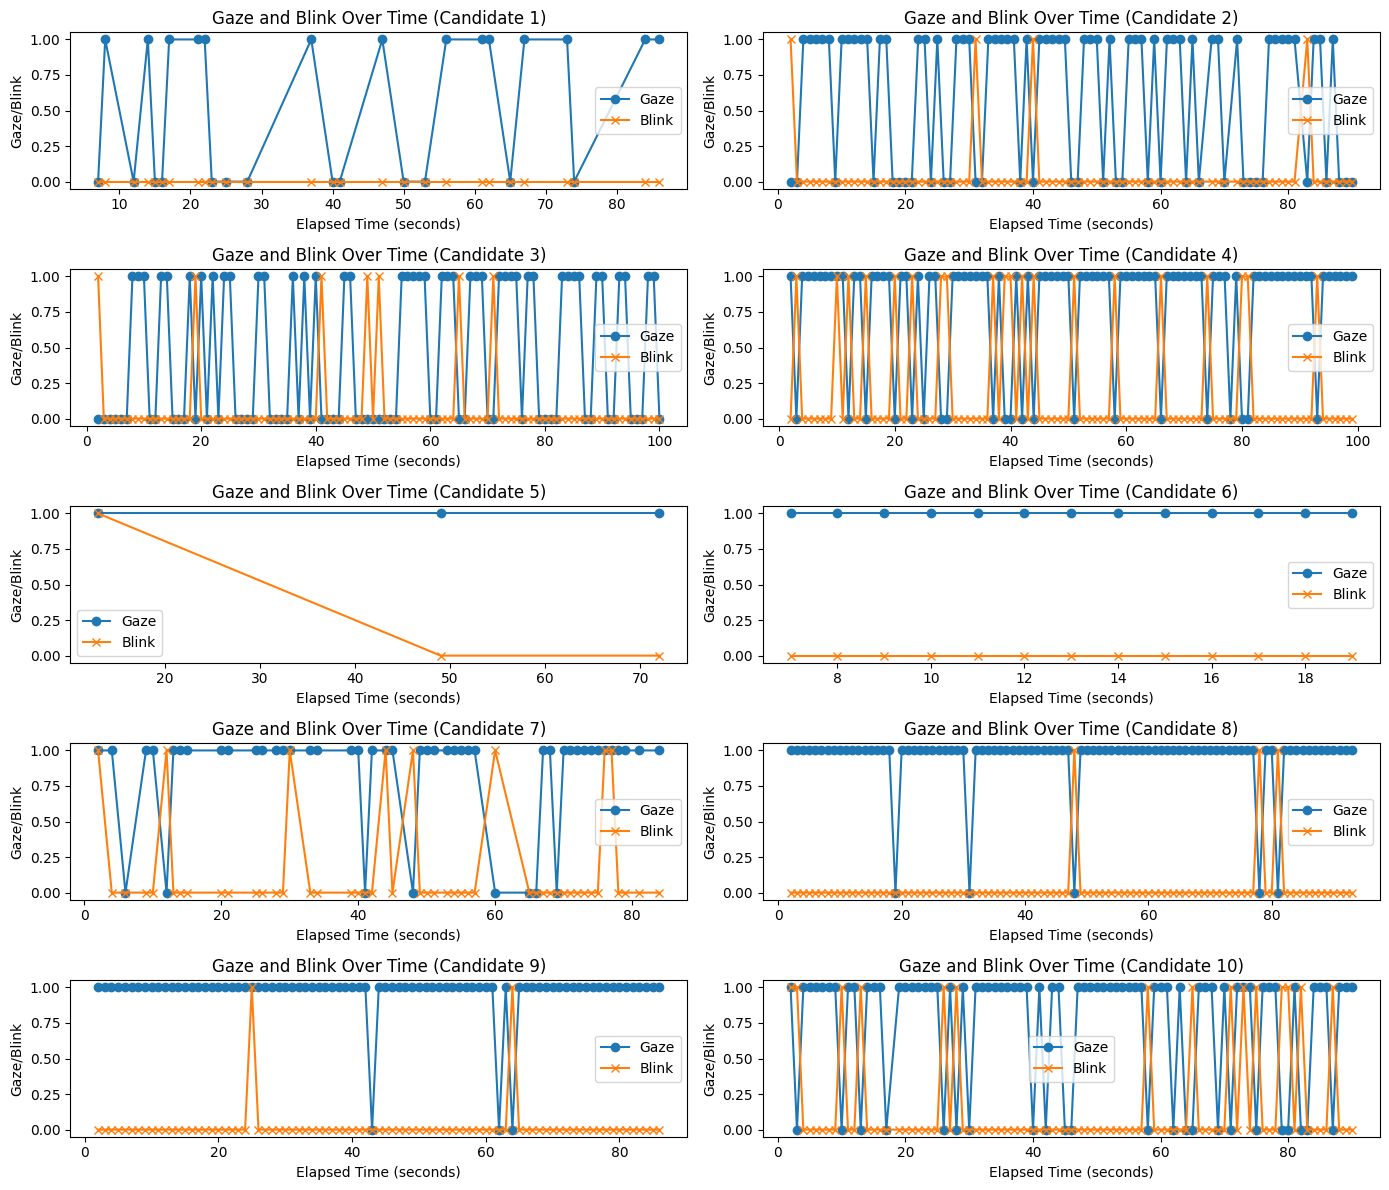

In [ ]:
# Initialize an empty list to store data for plotting
candidates_data = []

# Loop through each candidate's data file
for candidate_number in range(1, 11):
    # Load the emotion, gaze, and metadata data
    emotion_file_path = os.path.join(emotion_data_base_dir, str(candidate_number), 'emotion.csv')
    gaze_file_path = os.path.join(emotion_data_base_dir, str(candidate_number), 'gaze.csv')
    metadata_file_path = os.path.join(emotion_data_base_dir, str(candidate_number), 'metadata.csv')

    emotion_data = pd.read_csv(emotion_file_path)
    gaze_data = pd.read_csv(gaze_file_path)
    metadata_data = pd.read_csv(metadata_file_path)

    # Merge the data on common columns ('movie_id', 'image_seq', 'candidate_id')
    merged_data = pd.merge(emotion_data, gaze_data, on=['movie_id', 'image_seq'])
    merged_data = pd.merge(merged_data, metadata_data, on=['movie_id', 'image_seq'])

    # Add a column for candidate_id if not already present
    merged_data['candidate_id'] = candidate_number

    # Store the data for plotting
    candidates_data.append(merged_data)

# Plotting
plt.figure(figsize=(14, 12))
for i, candidate_data in enumerate(candidates_data, start=1):
    plt.subplot(5, 2, i)  # 5 rows, 2 columns, i-th subplot
    plt.plot(candidate_data['elapsed_time'], candidate_data['gaze'], label='Gaze', marker='o')
    plt.plot(candidate_data['elapsed_time'], candidate_data['blink'], label='Blink', marker='x')
    plt.title(f'Gaze and Blink Over Time (Candidate {candidate_data["candidate_id"].iloc[0]})')
    plt.xlabel('Elapsed Time (seconds)')
    plt.ylabel('Gaze/Blink')
    plt.legend()

plt.tight_layout()
plt.show()


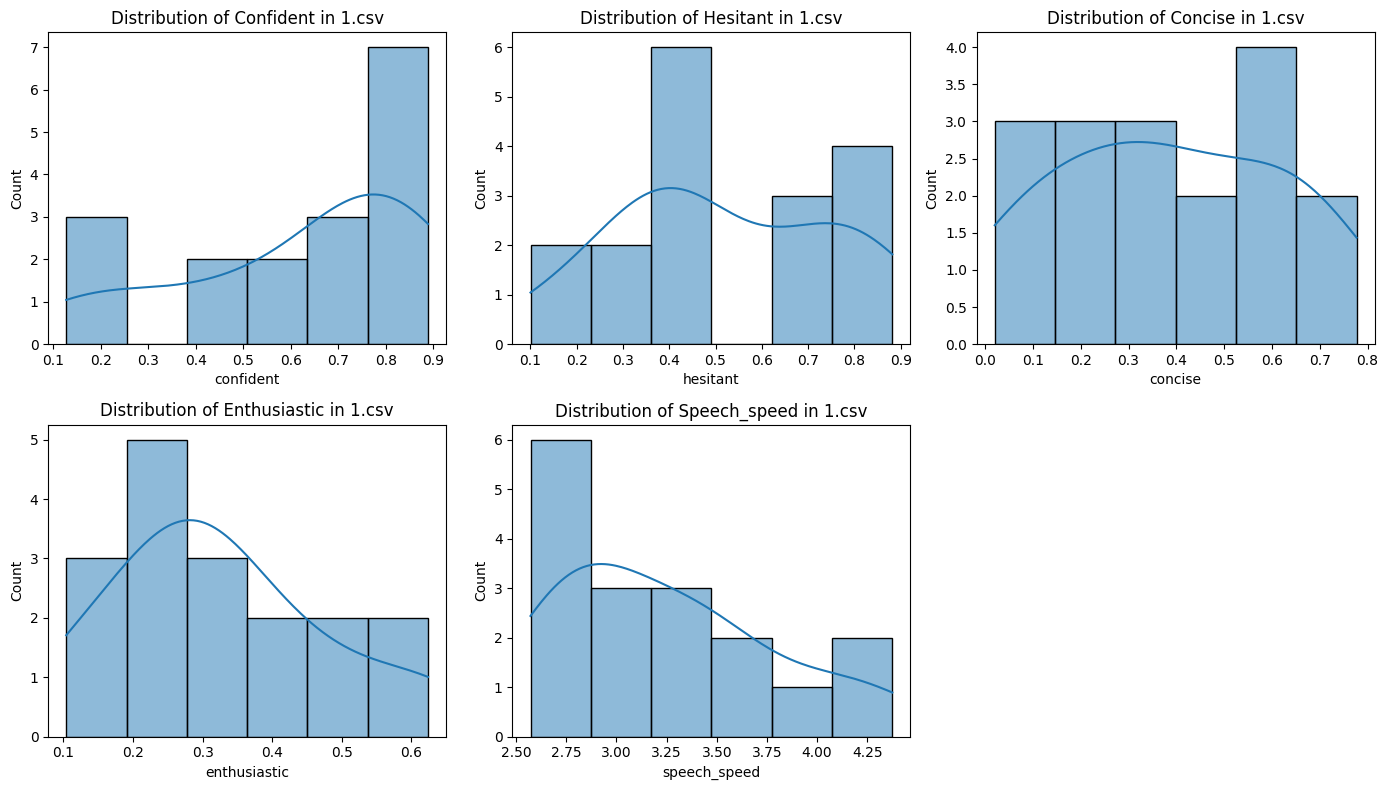

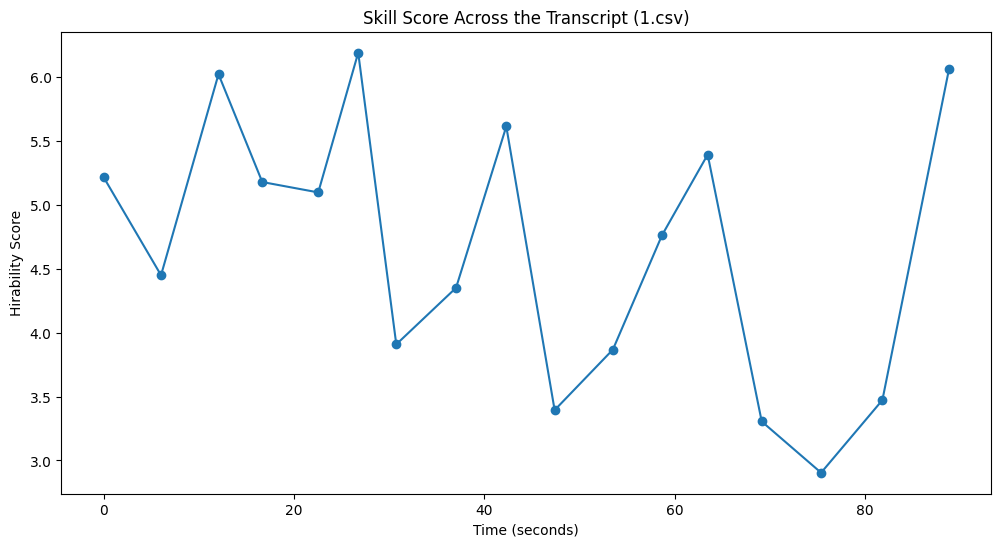

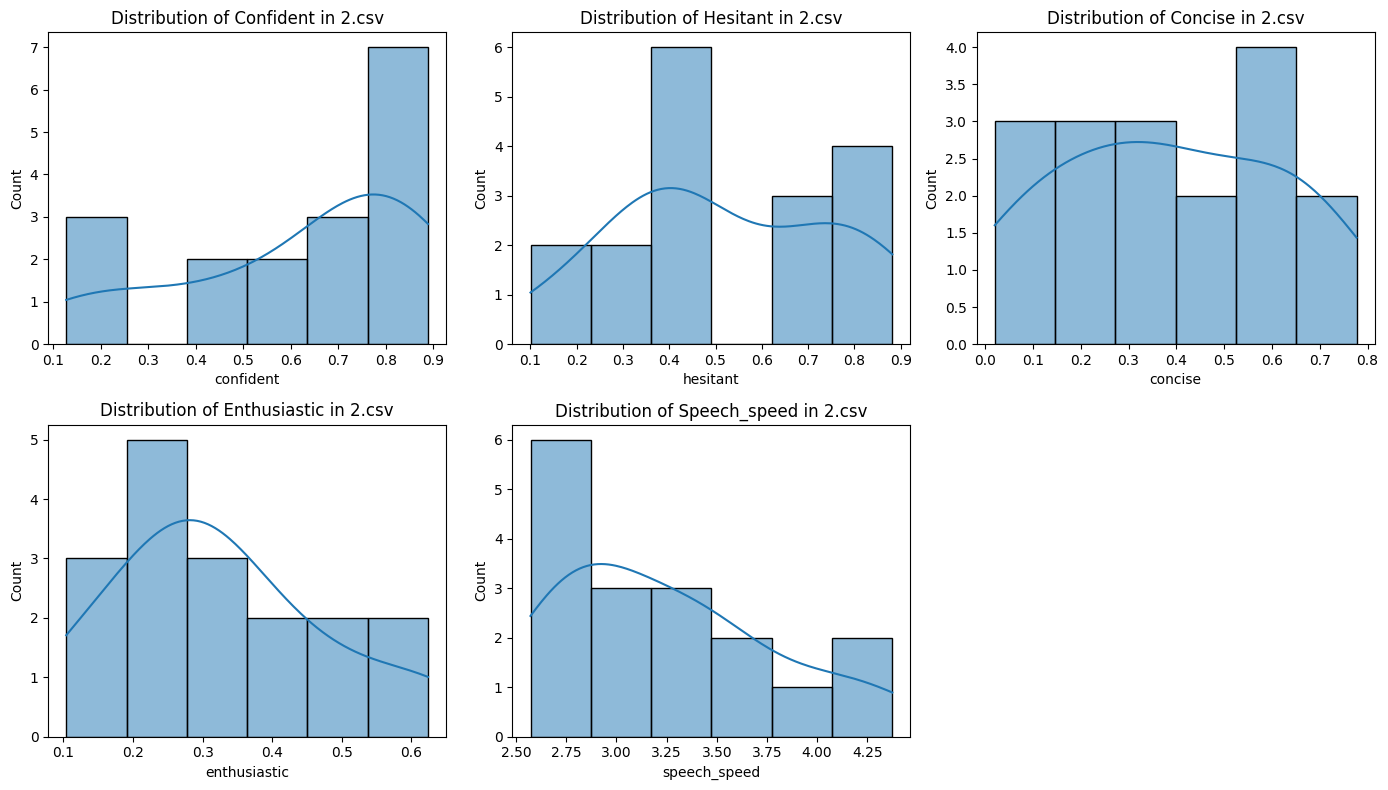

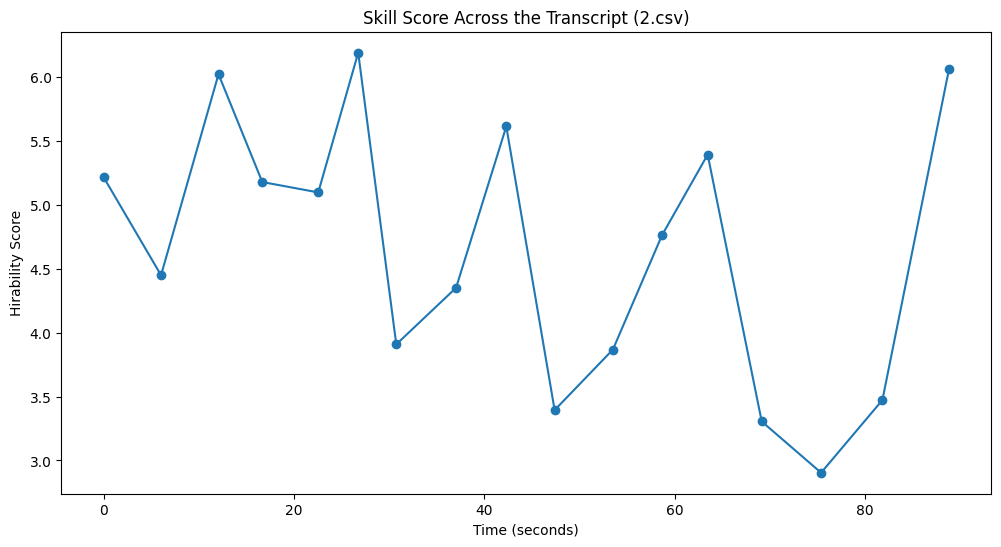

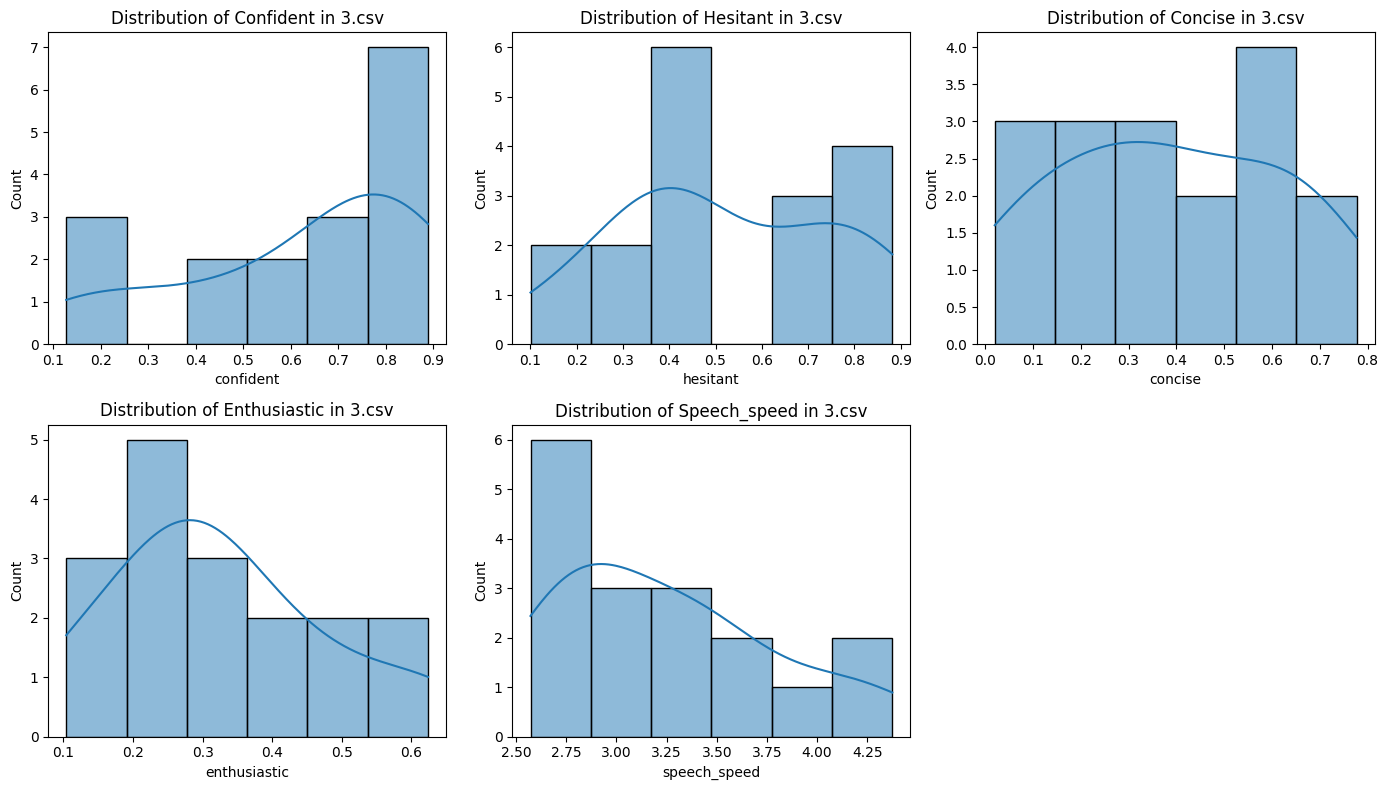

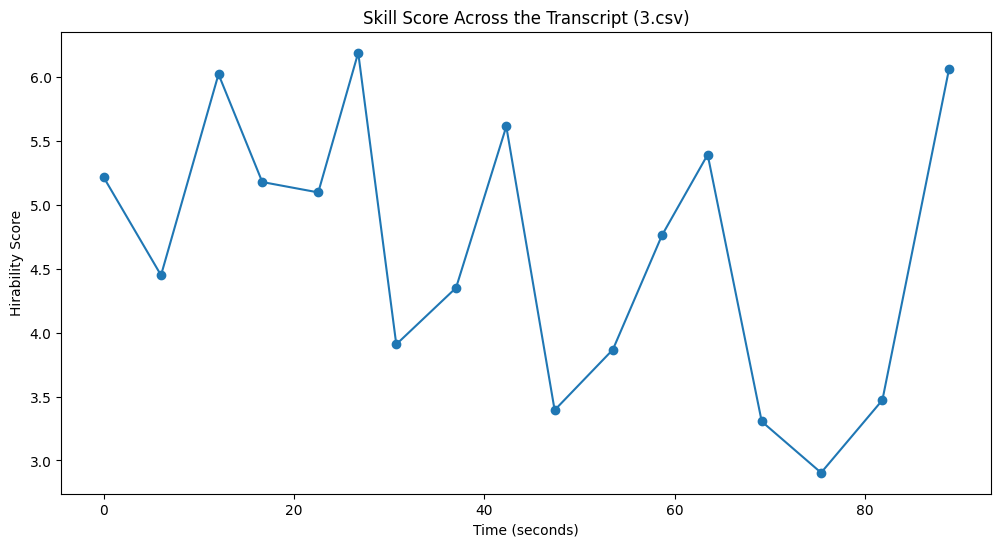

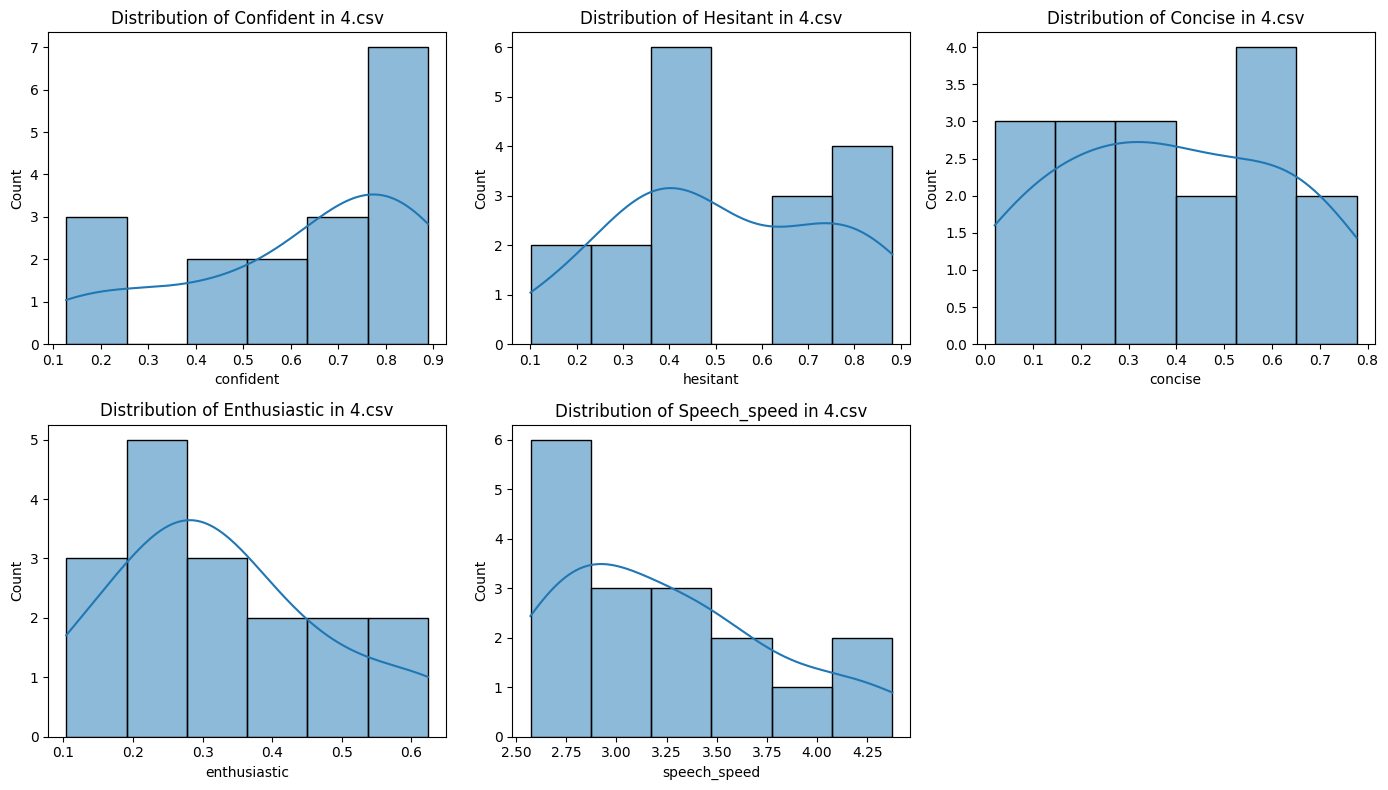

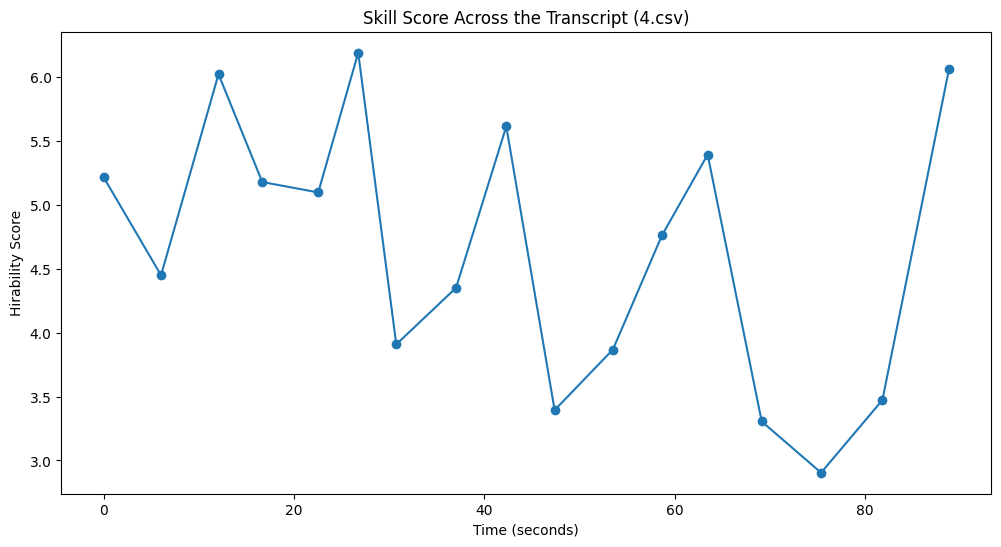

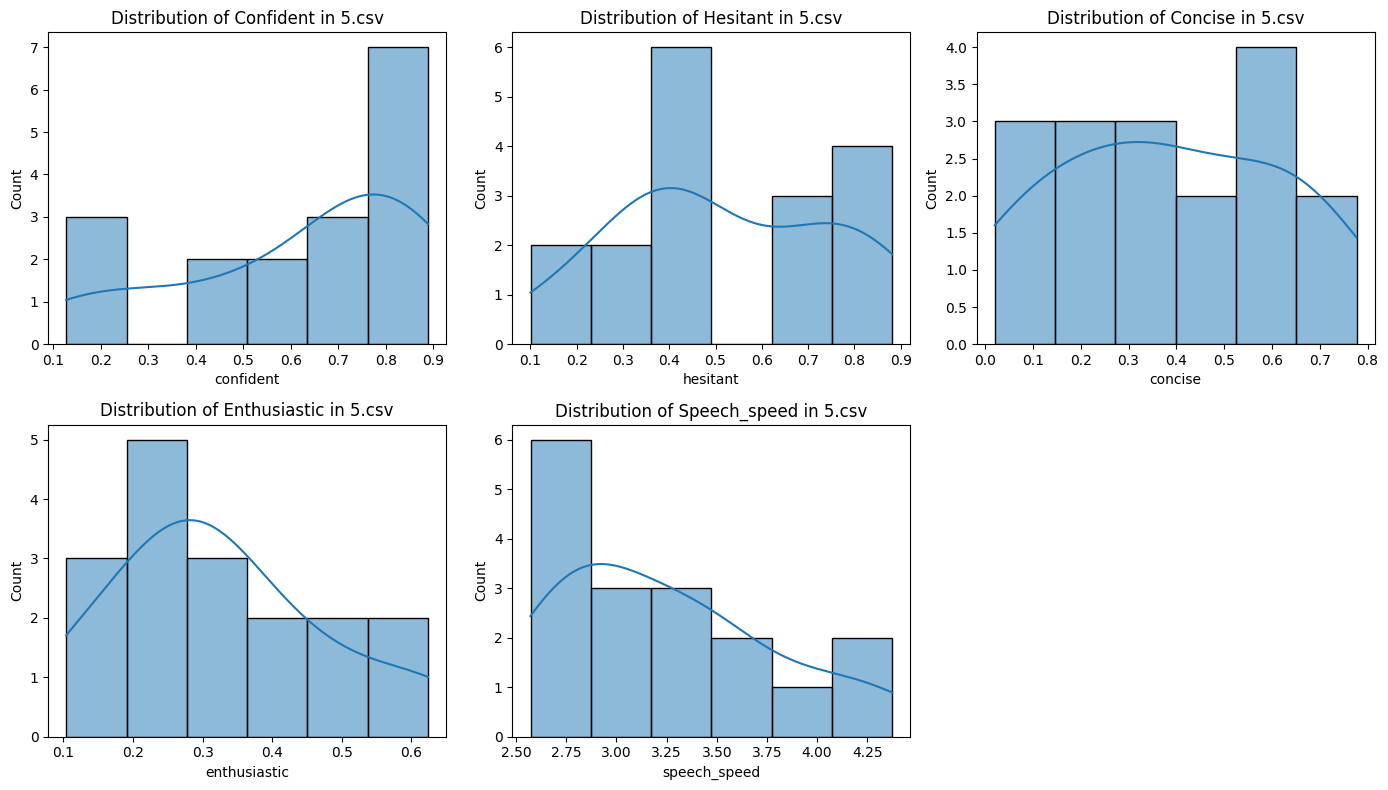

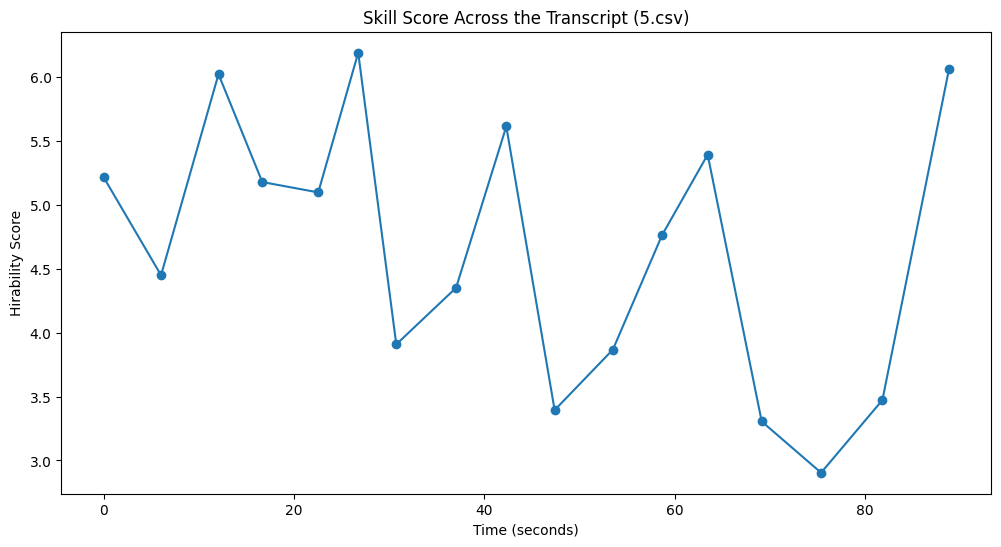

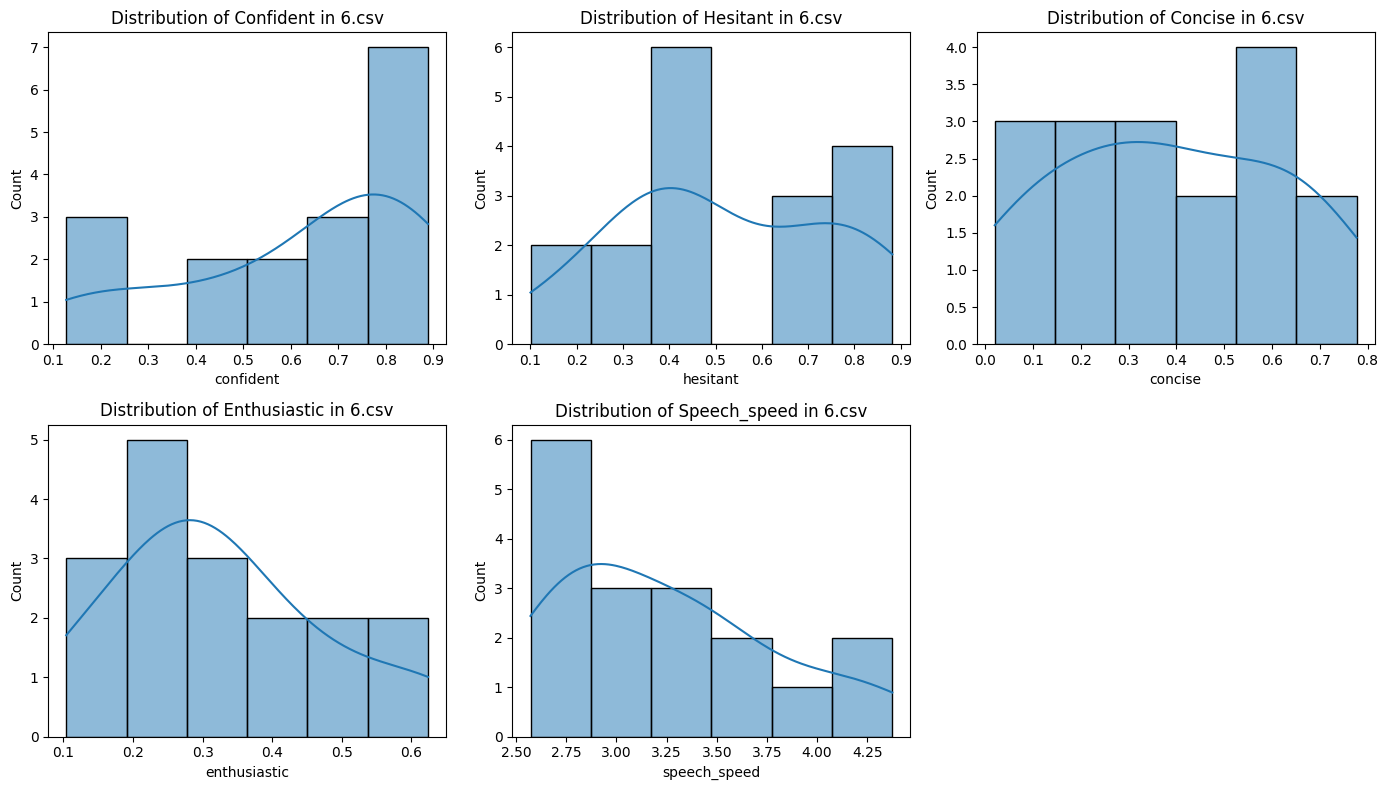

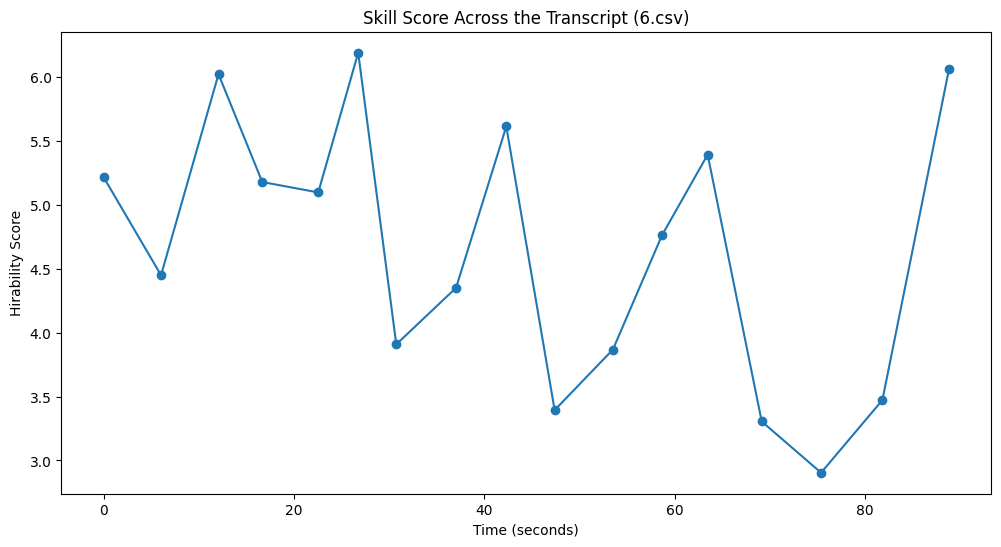

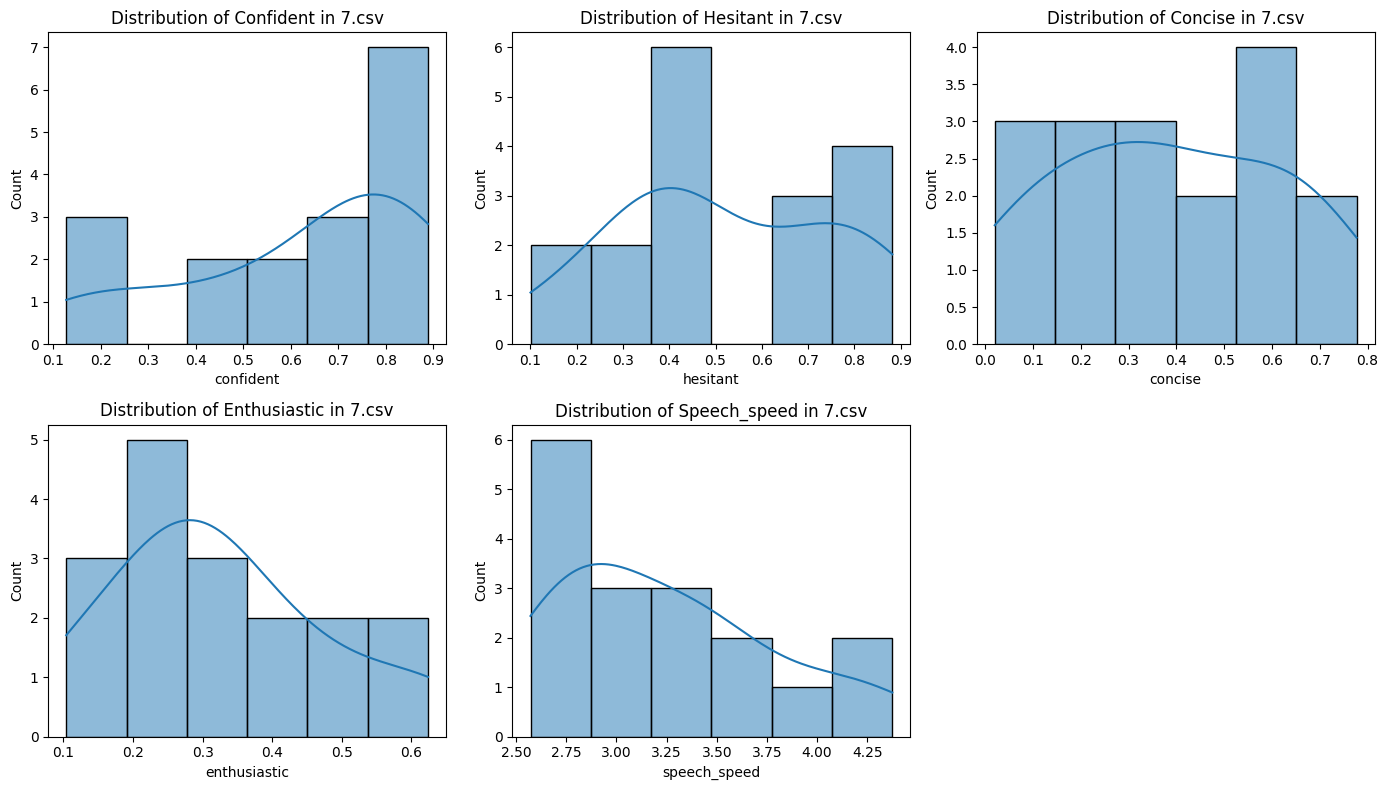

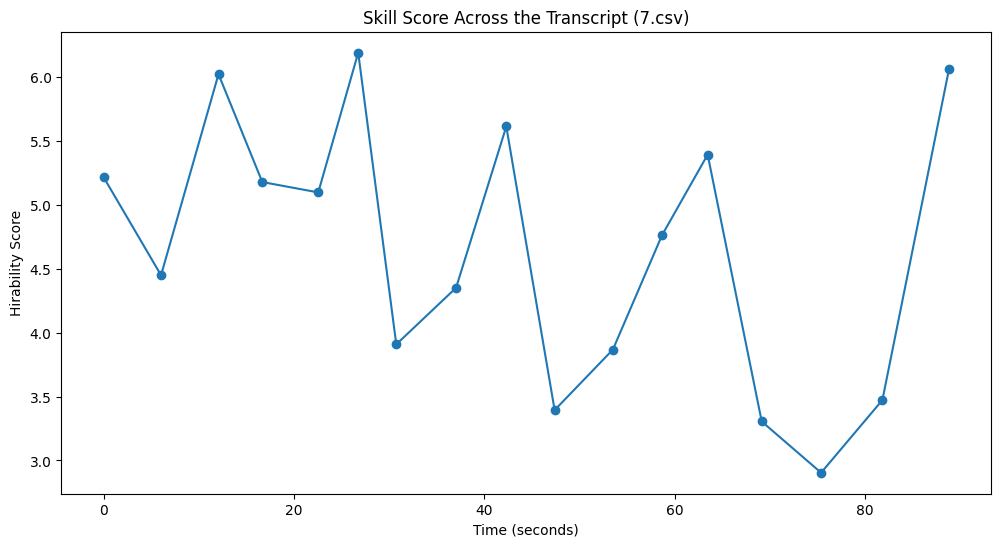

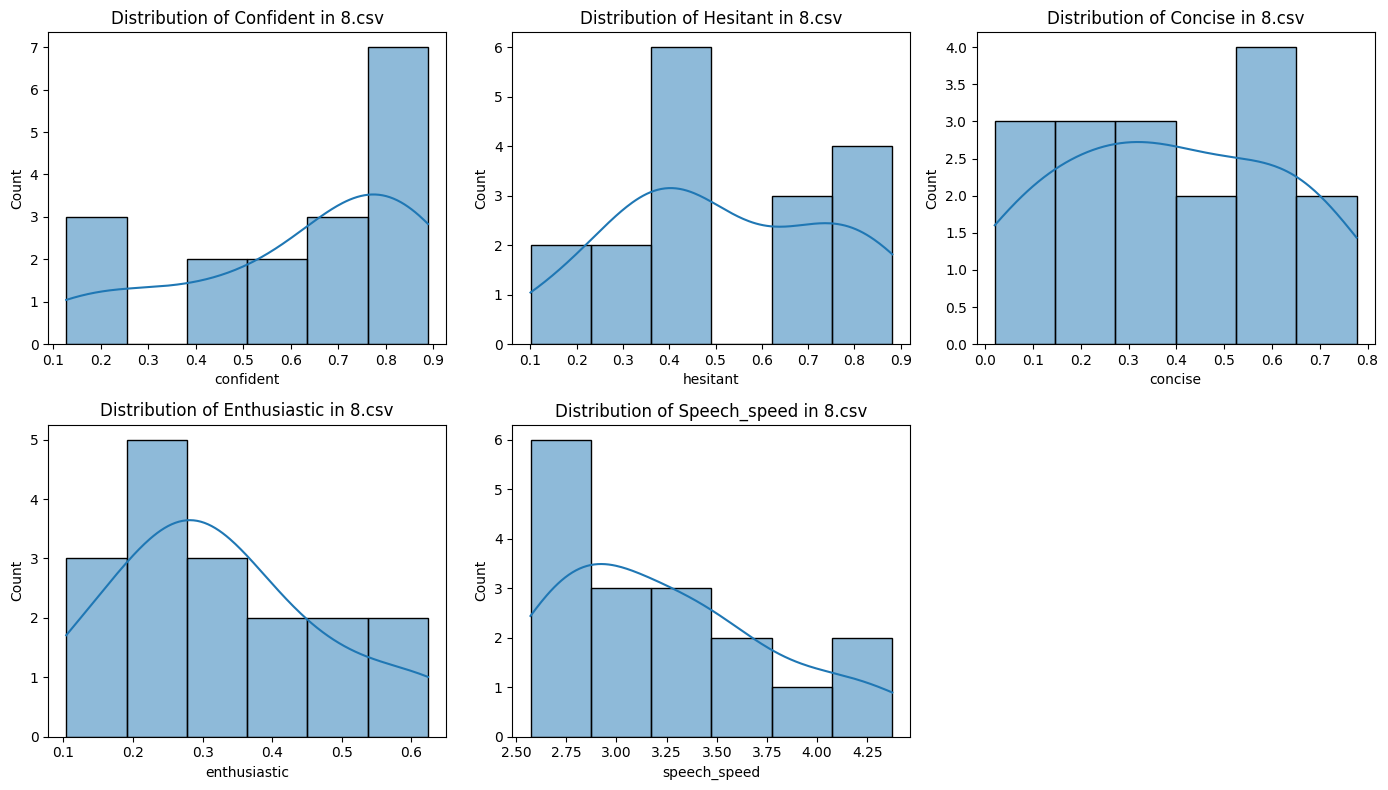

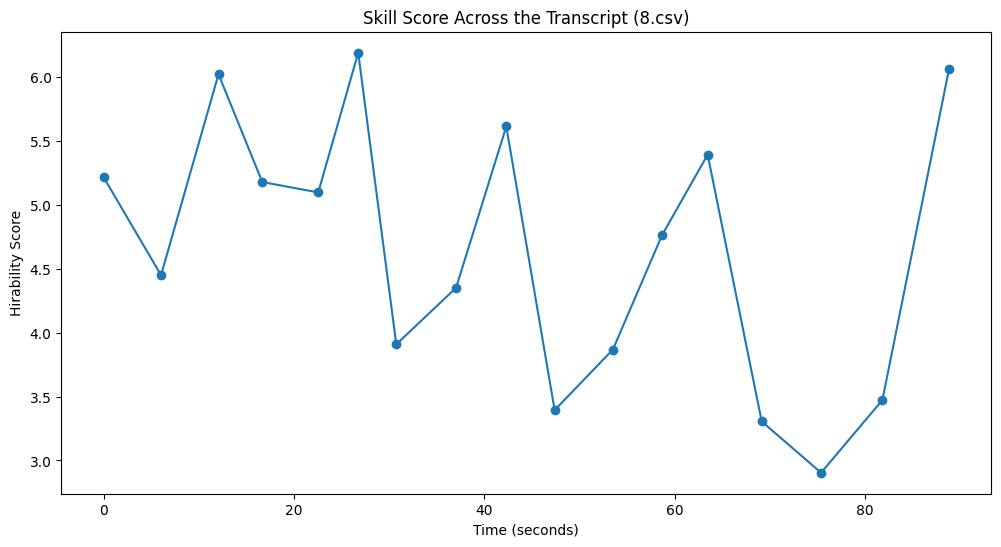

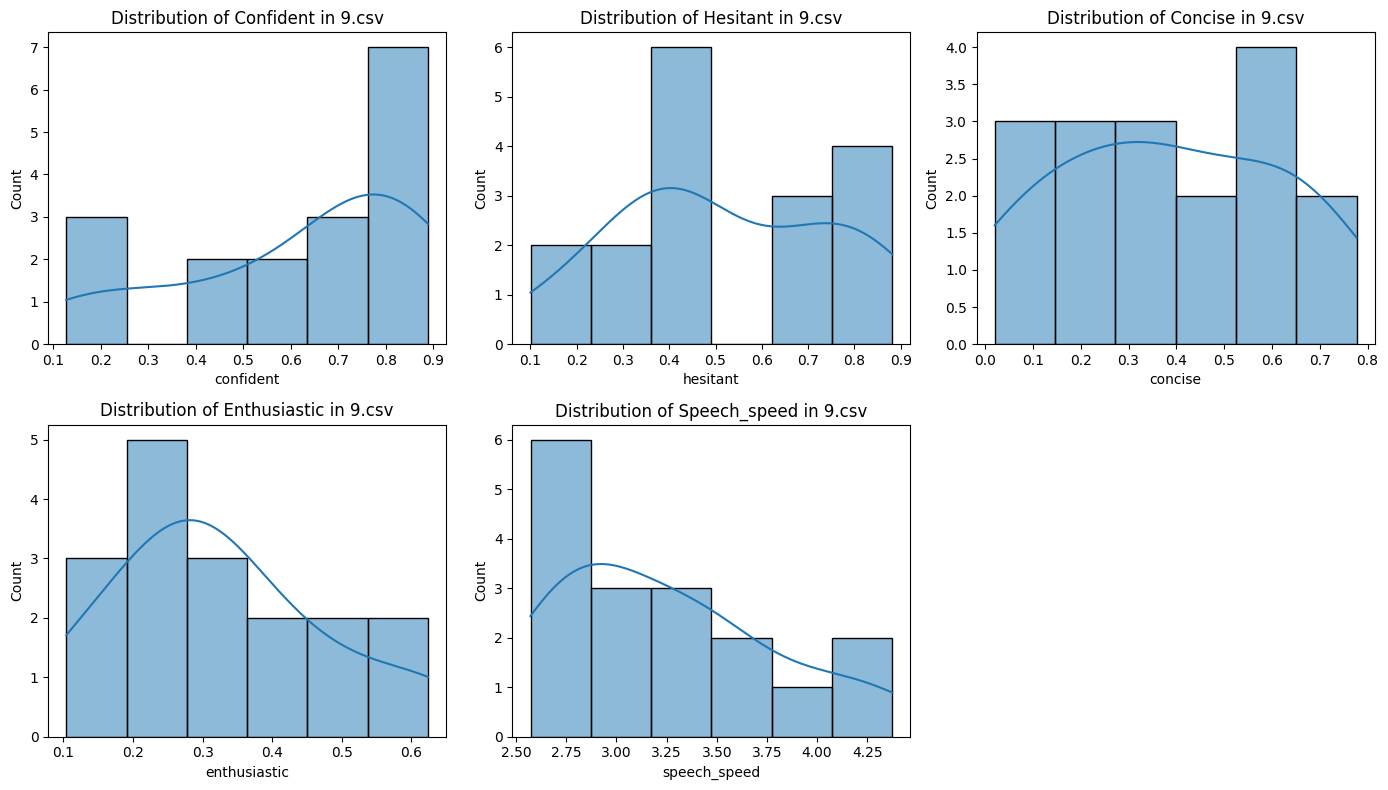

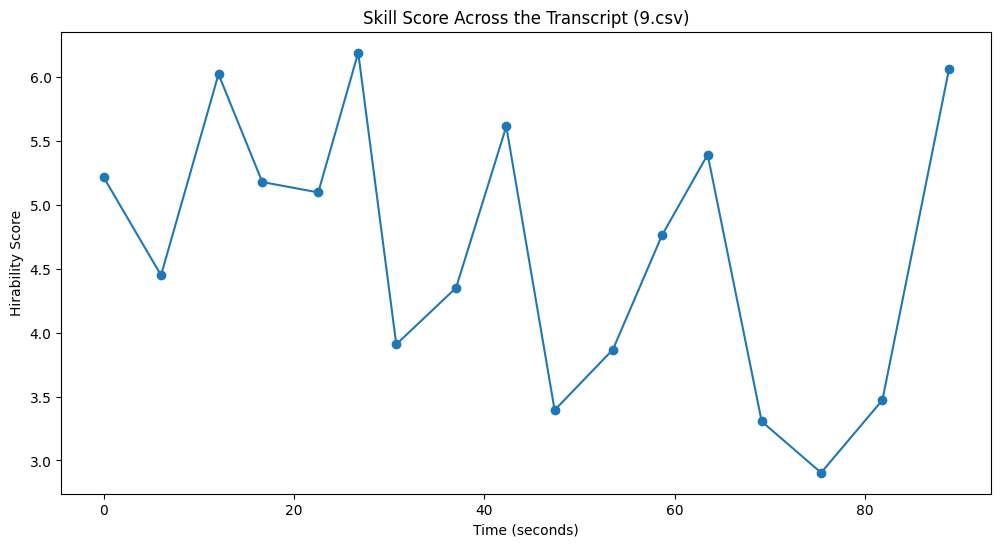

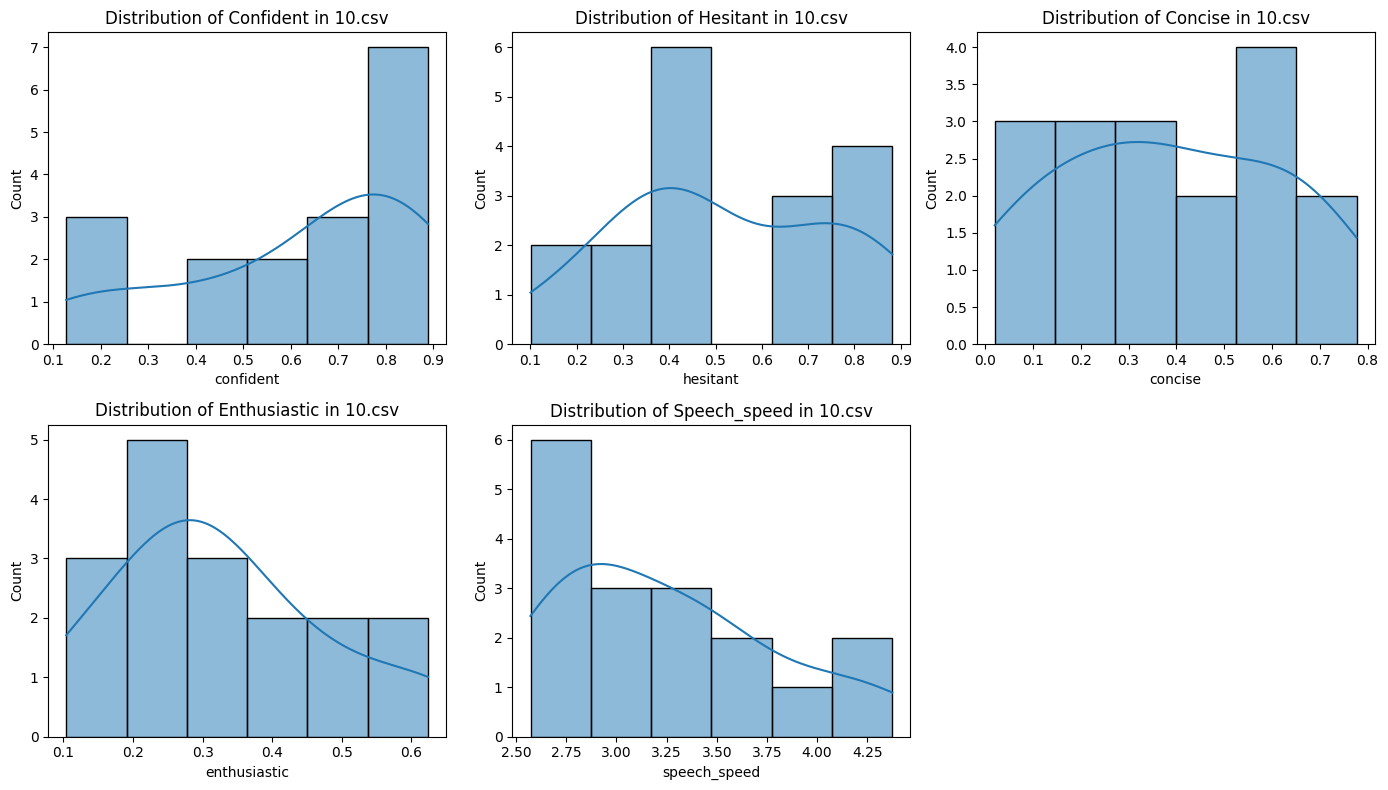

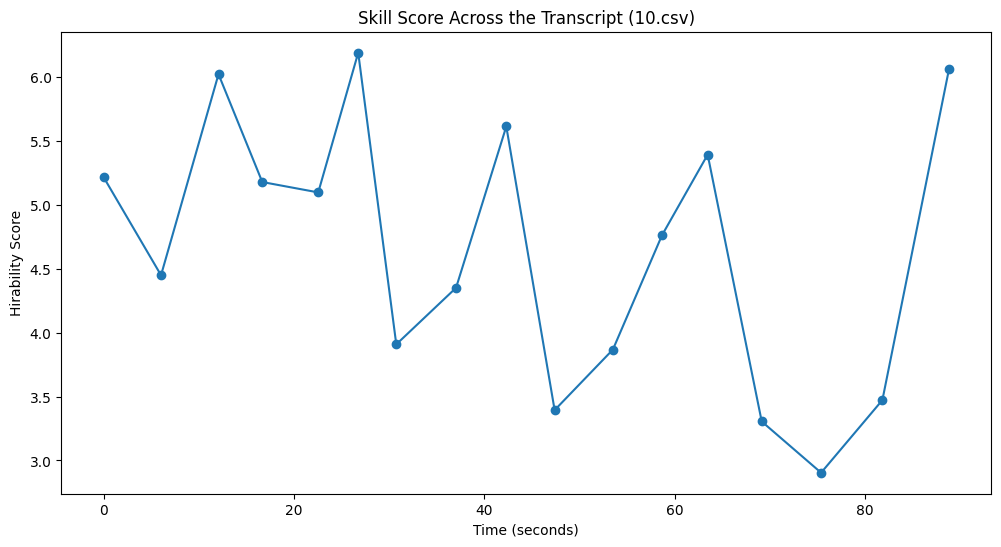

In [ ]:
# Analyze and plot distributions in the transcript data
for candidate_number in range(1, 11):
  features = ['confident', 'hesitant', 'concise', 'enthusiastic', 'speech_speed']

  plt.figure(figsize=(14, 8))
  for i, feature in enumerate(features):
      plt.subplot(2, 3, i+1)
      sns.histplot(transcript_data[feature], kde=True)
      plt.title(f'Distribution of {feature.capitalize()} in {candidate_number}.csv')
  plt.tight_layout()
  plt.show()

  # Generate skill scores
  transcript_data['Hirability_score'] = (
      transcript_data['confident'] * 2
      - transcript_data['hesitant'] * 1.5
      + transcript_data['concise'] * 1.2
      + transcript_data['enthusiastic'] * 1.5
      + transcript_data['speech_speed']
  )

  # Plot the skill score across the transcript
  plt.figure(figsize=(12, 6))
  plt.plot(transcript_data['start'], transcript_data['Hirability_score'], marker='o')
  plt.title(f'Skill Score Across the Transcript ({candidate_number}.csv)')
  plt.xlabel('Time (seconds)')
  plt.ylabel('Hirability Score')
  plt.show()

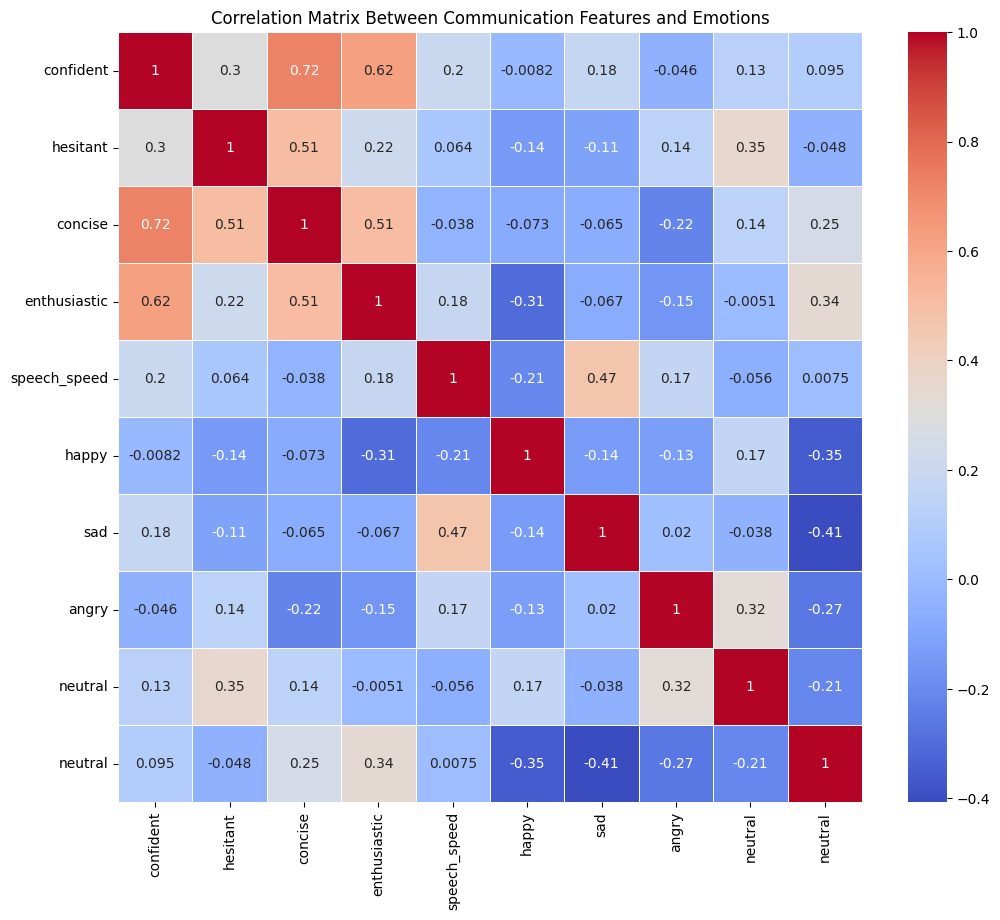

In [ ]:
combined_data = pd.concat([transcript_data, final_merged_data], axis=1)

# Select relevant columns for correlation analysis
correlation_columns = ['confident', 'hesitant', 'concise', 'enthusiastic', 'speech_speed',
                       'happy', 'sad', 'angry', 'neutral']

# Calculate correlation matrix
correlation_matrix = combined_data[correlation_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Between Communication Features and Emotions')
plt.show()

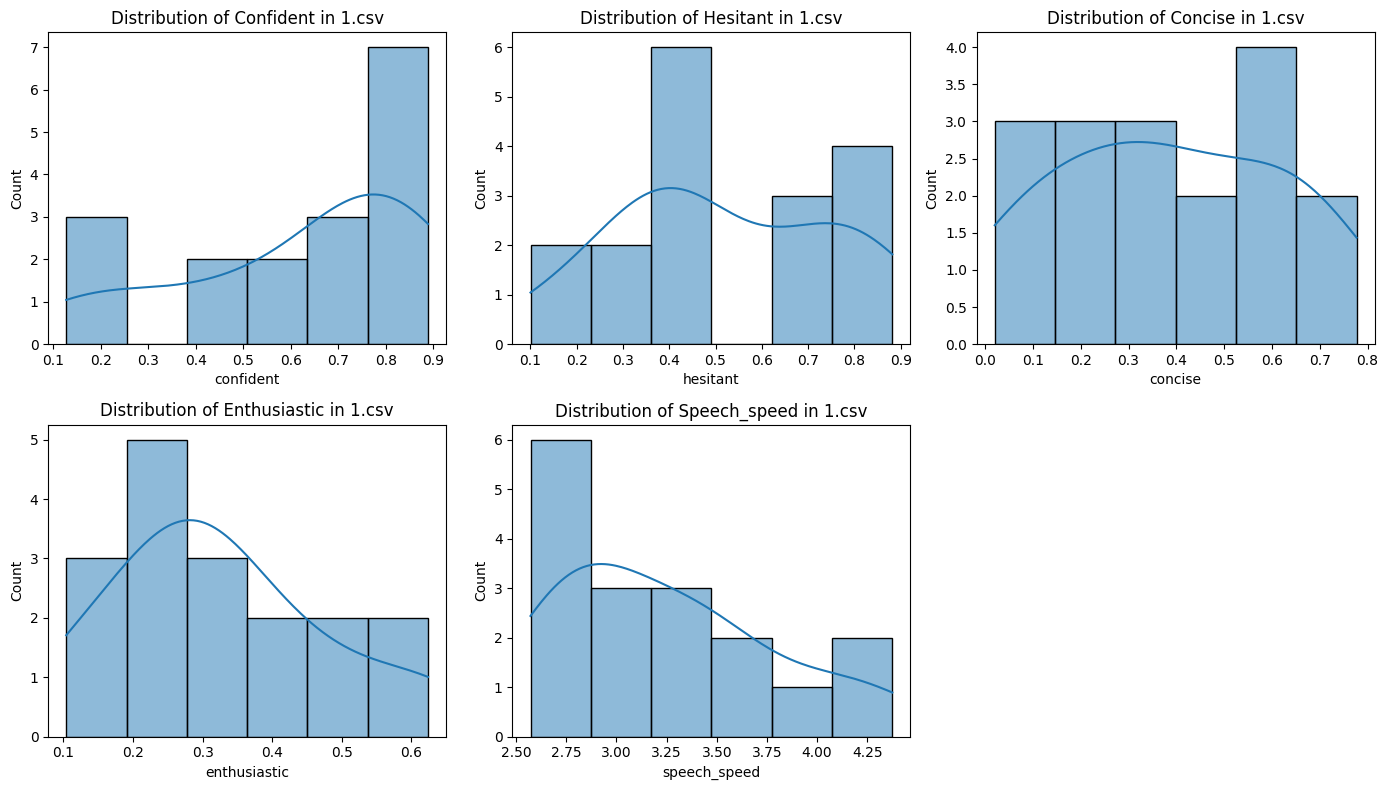

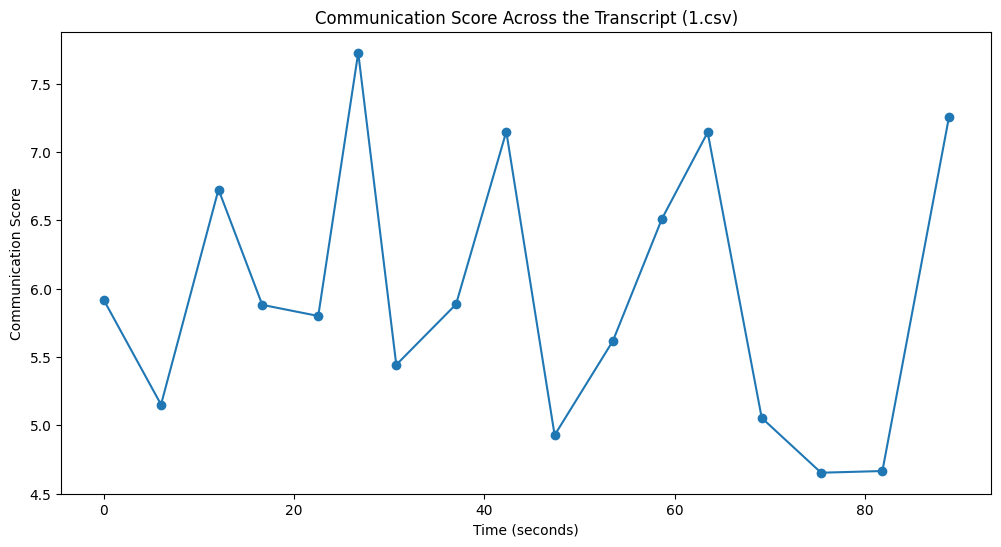

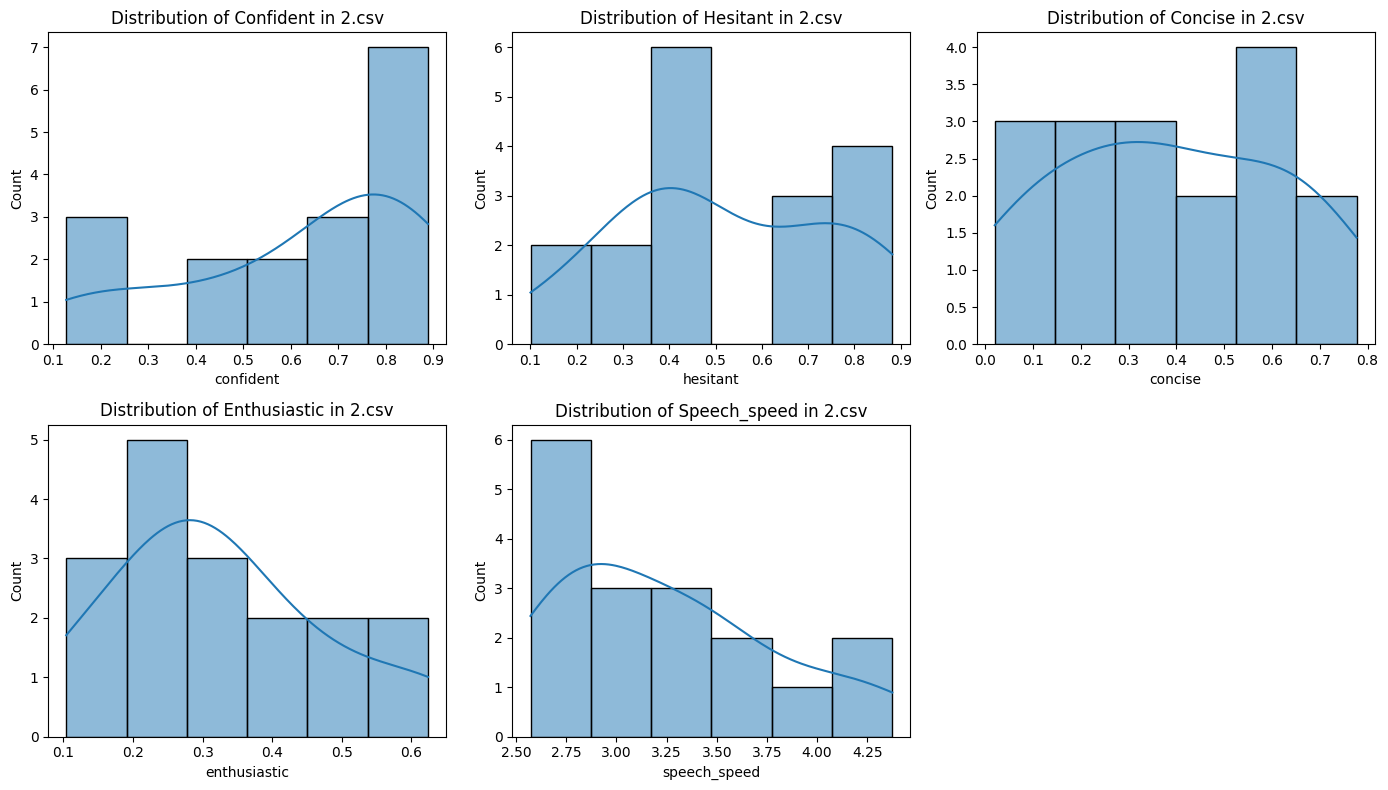

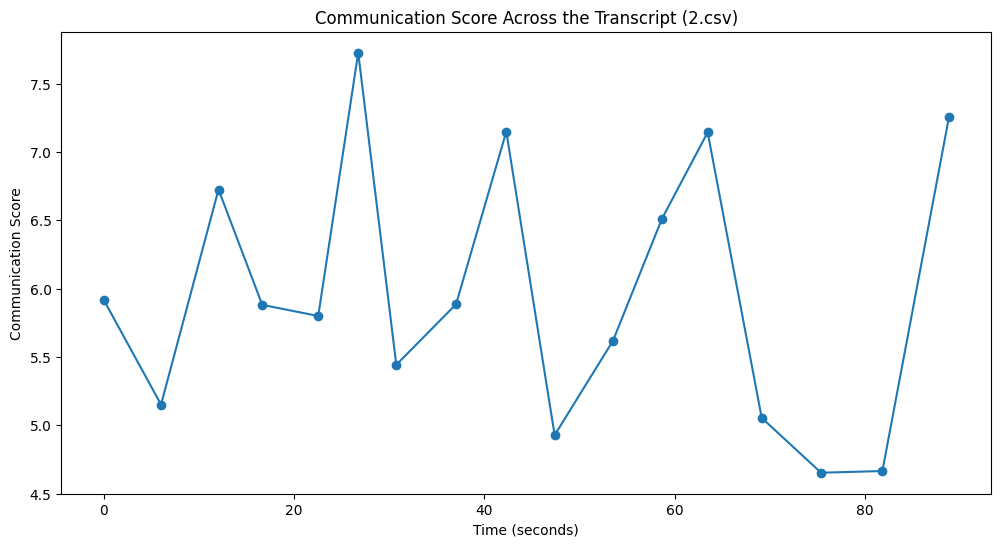

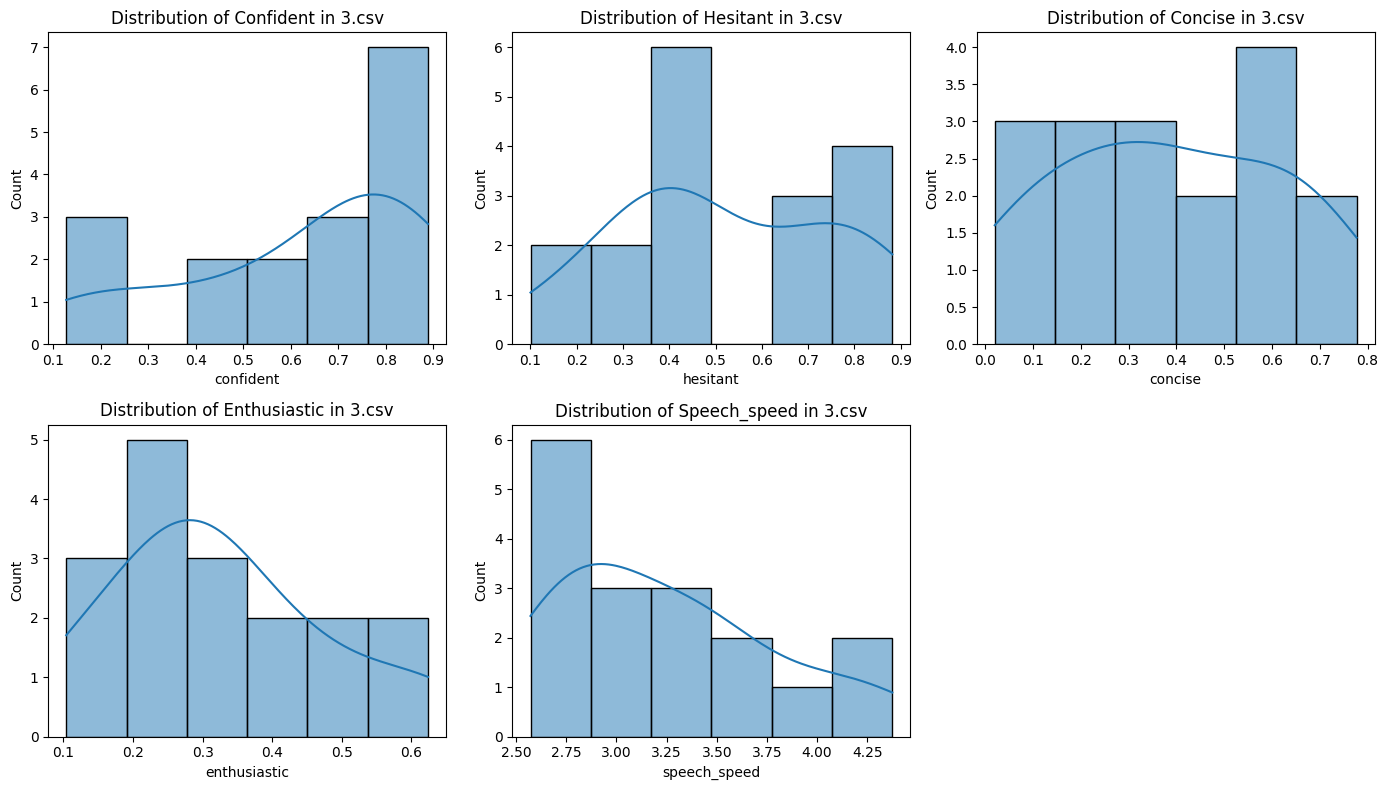

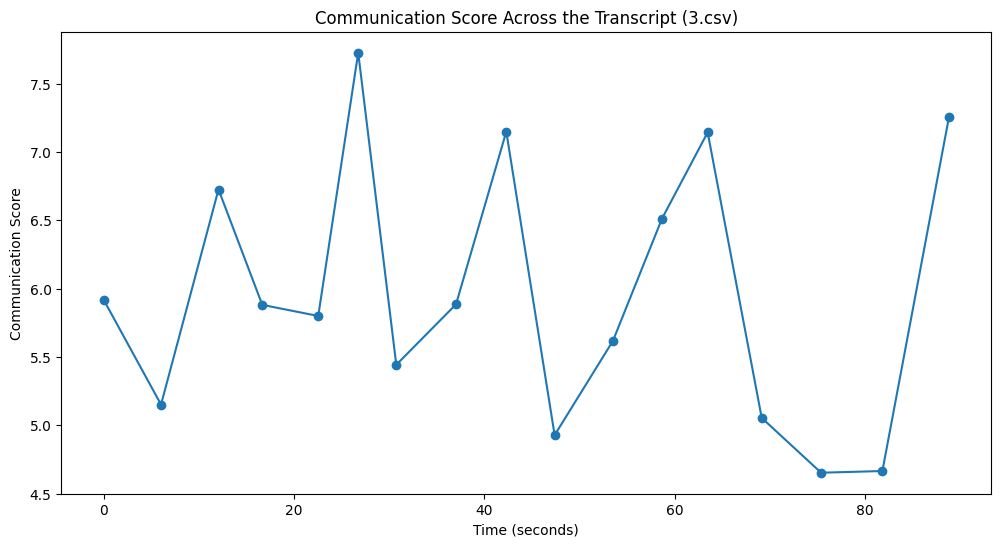

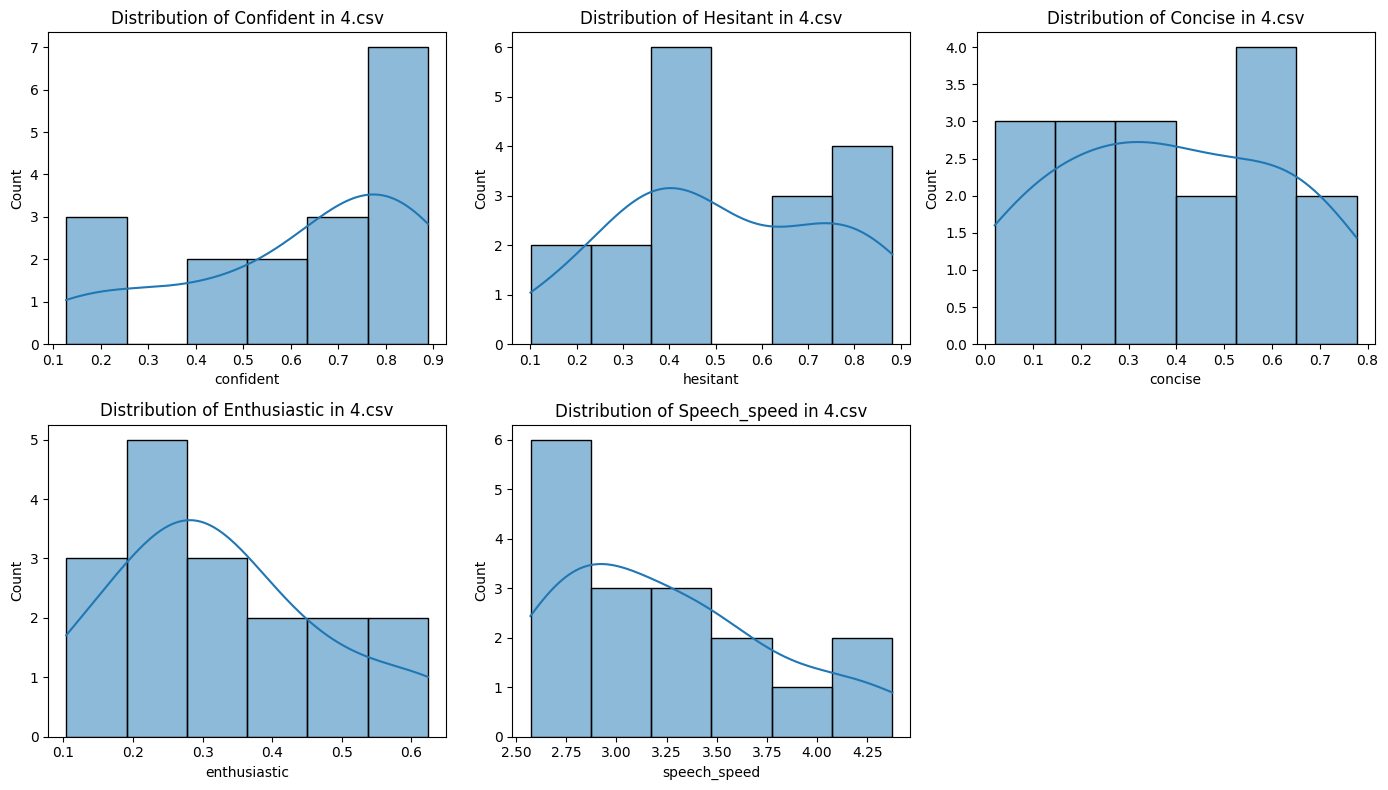

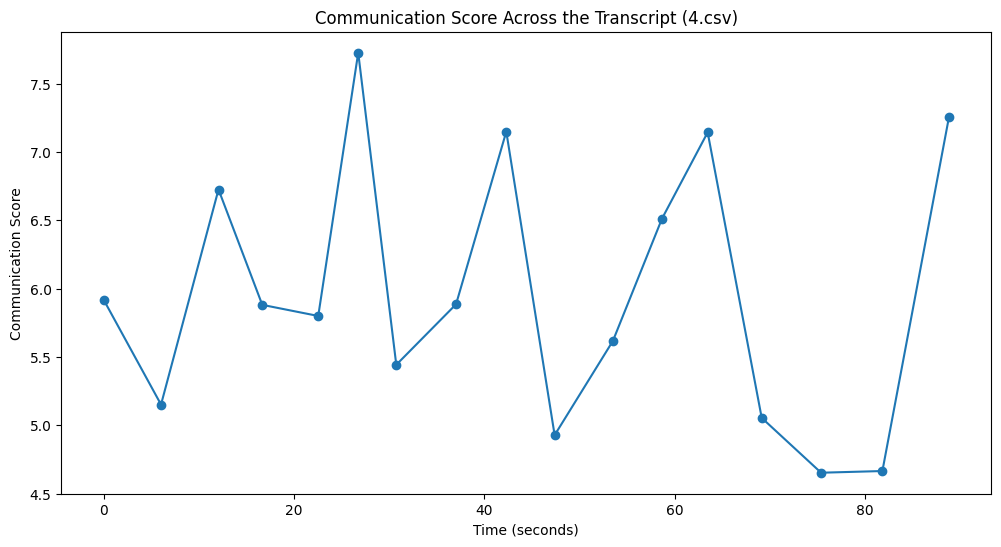

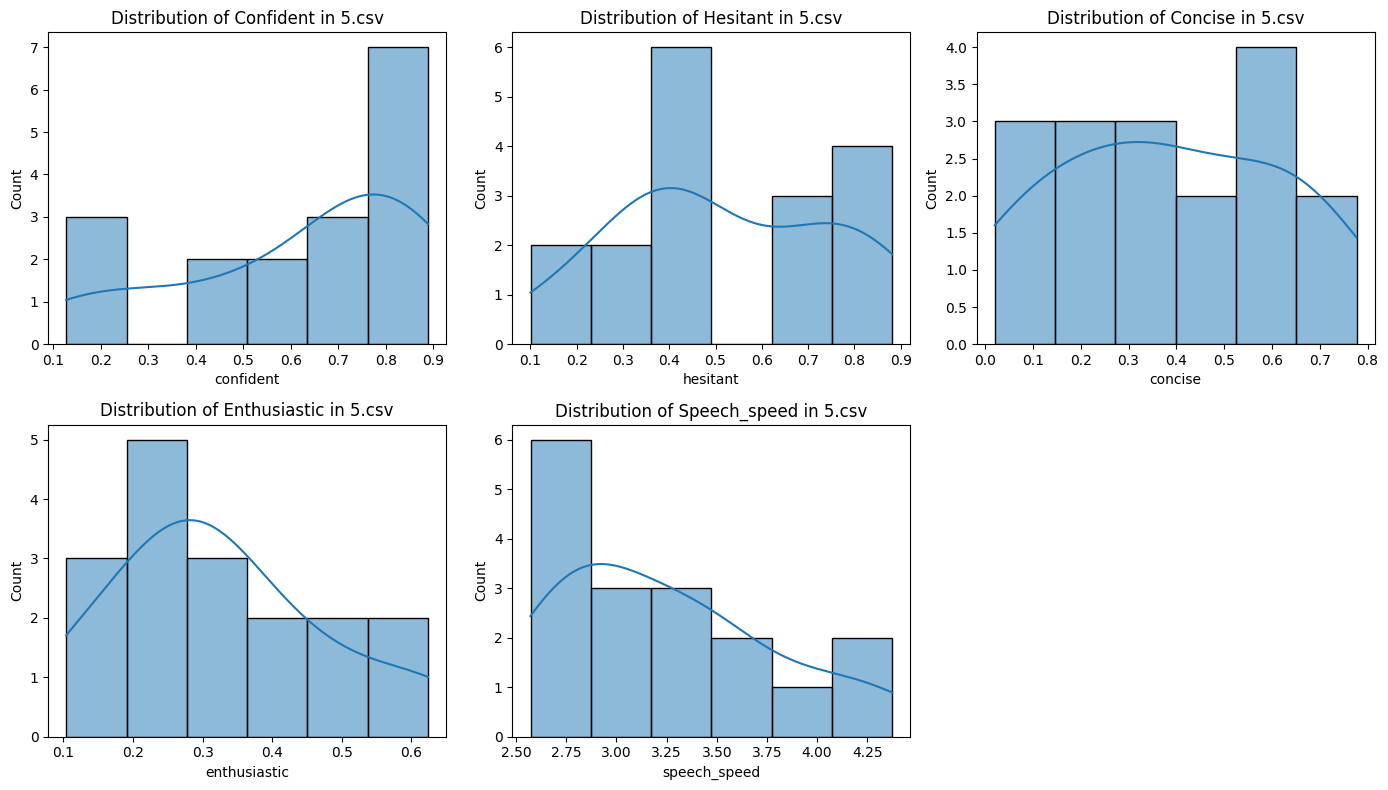

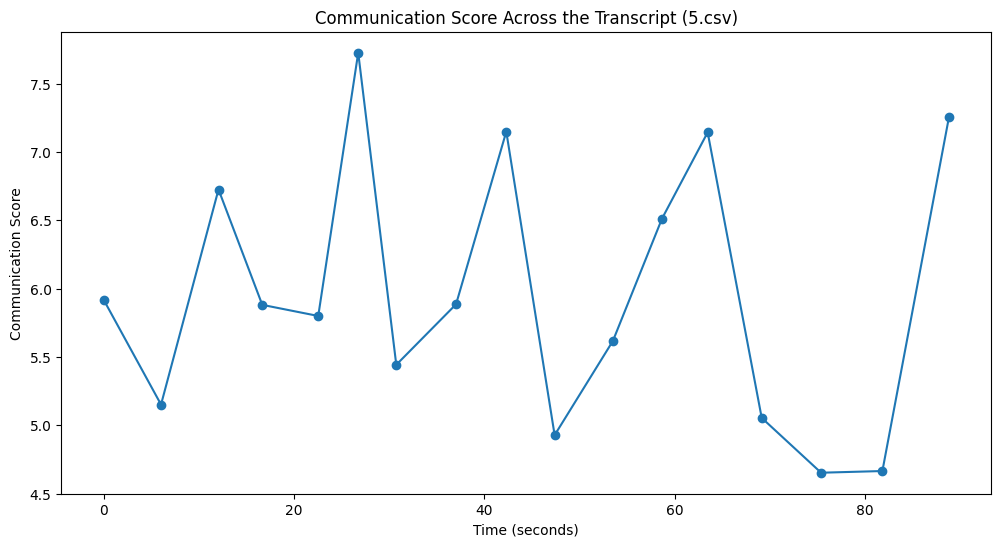

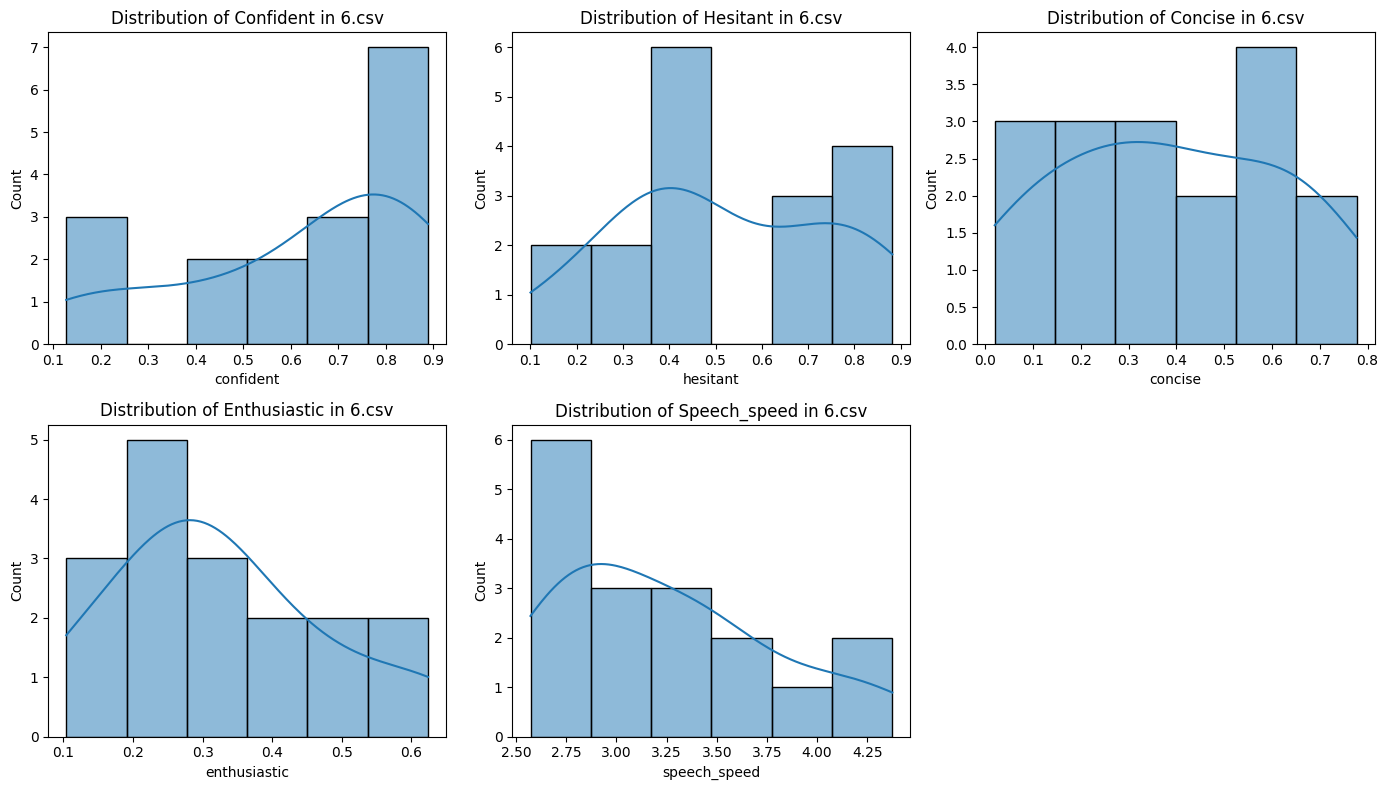

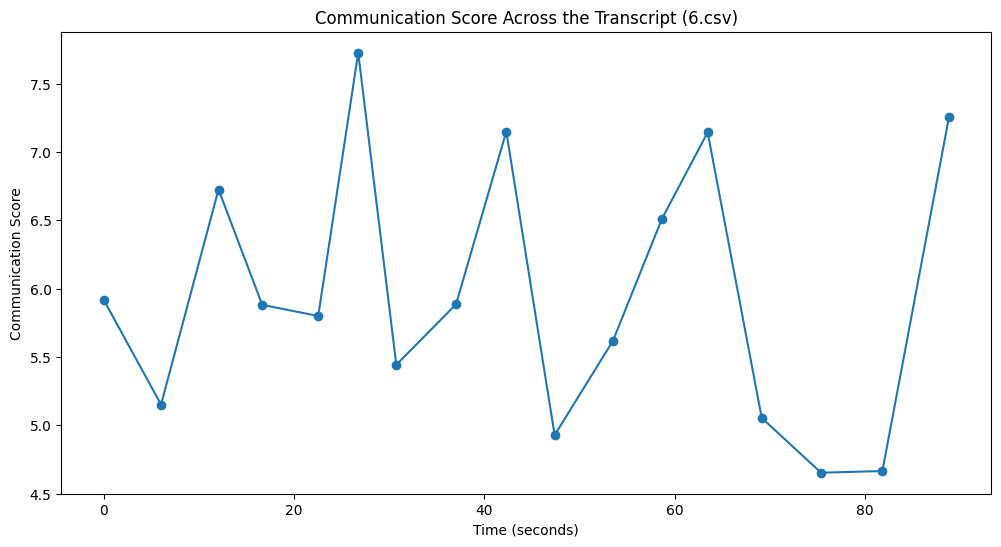

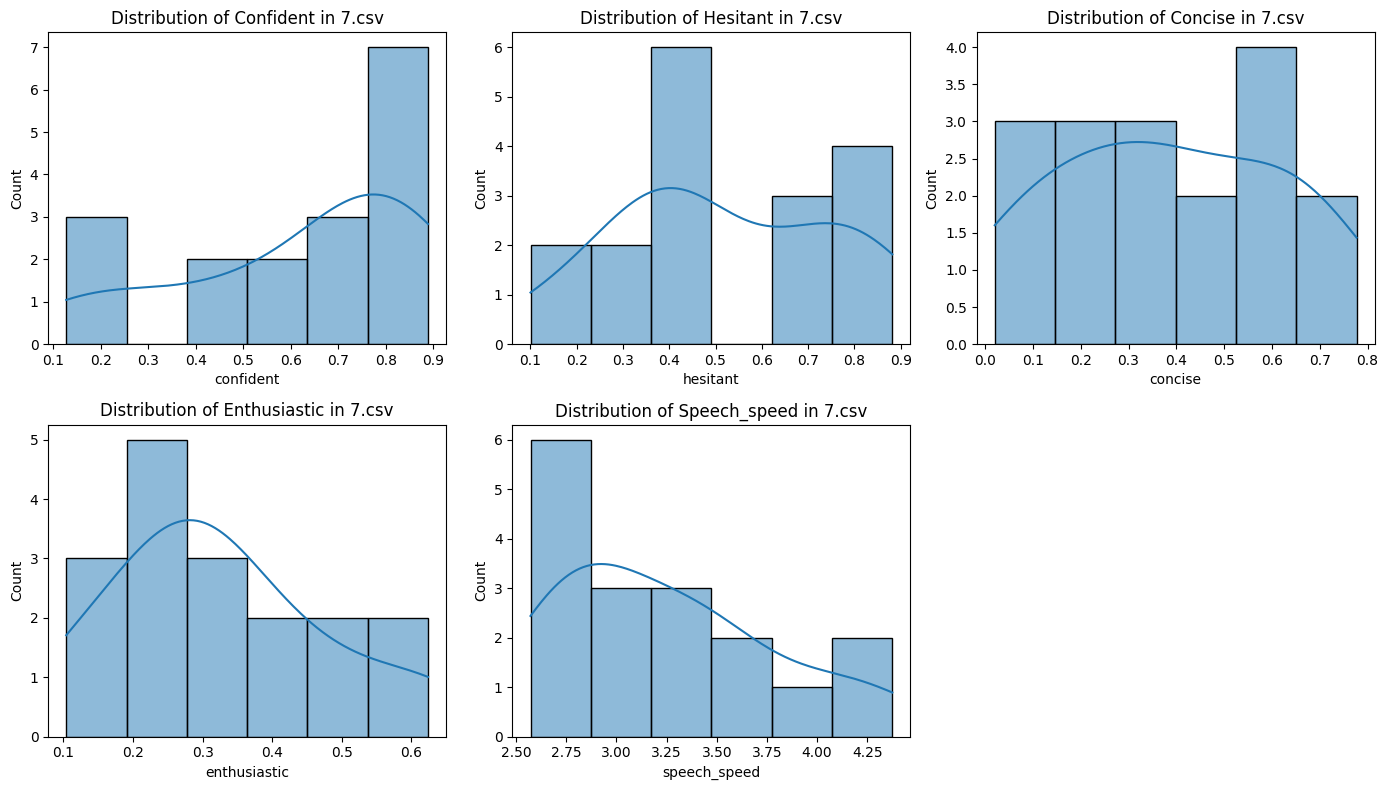

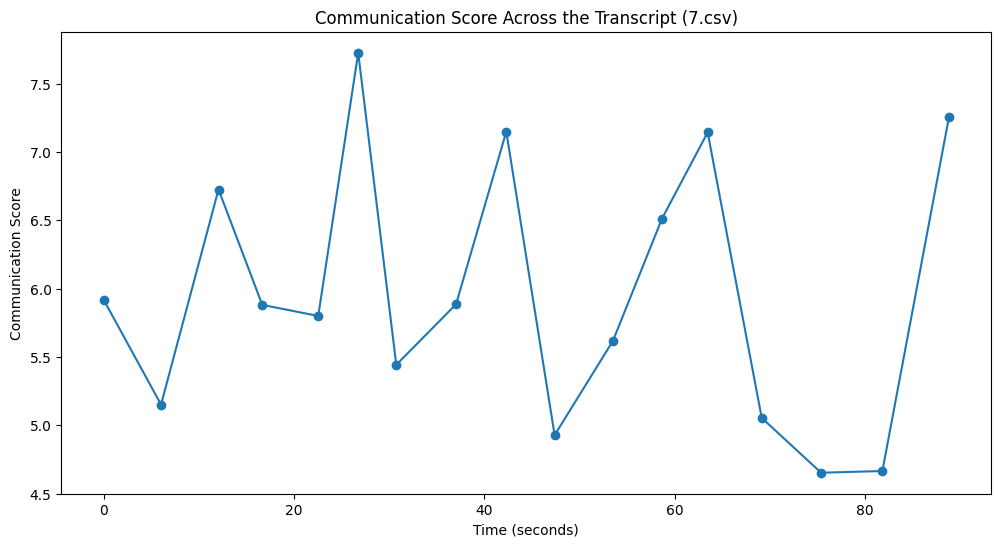

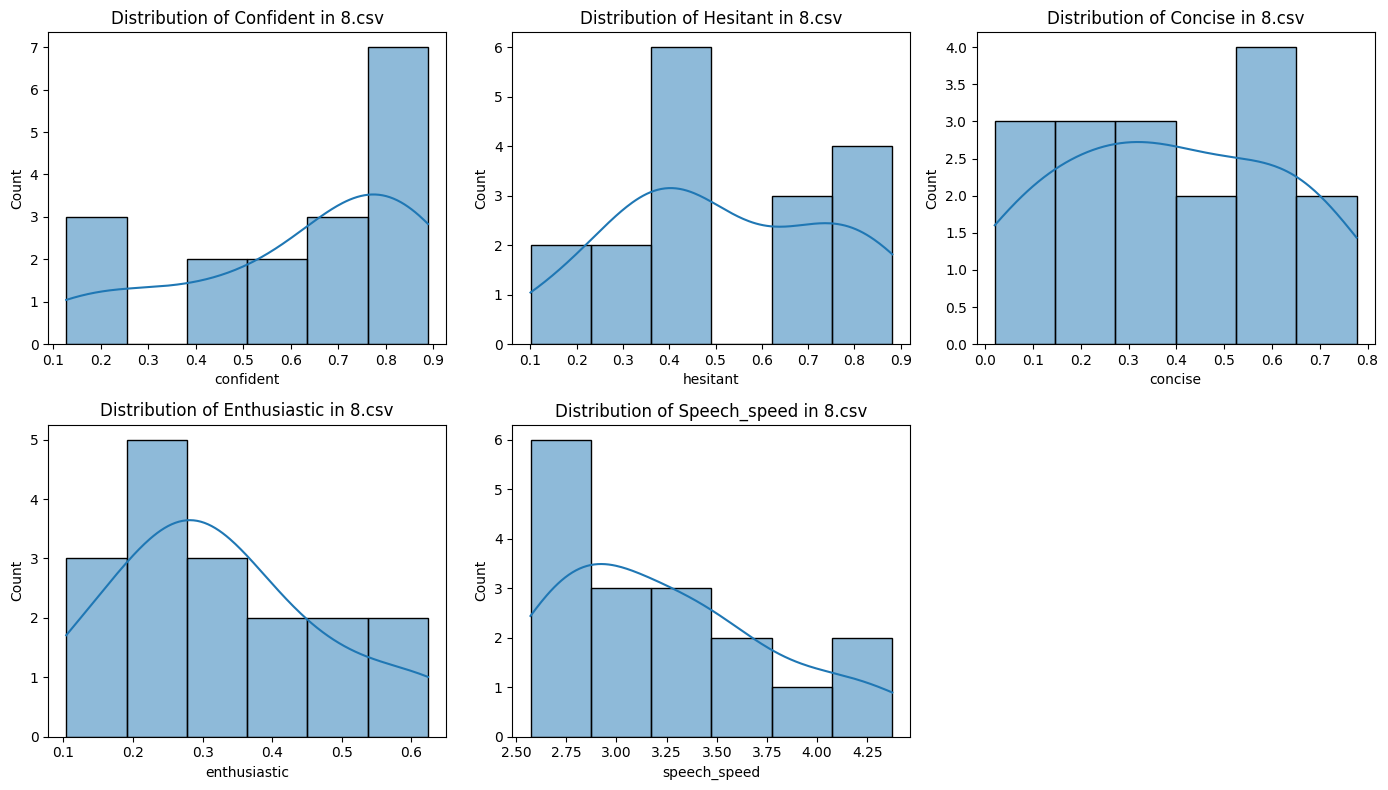

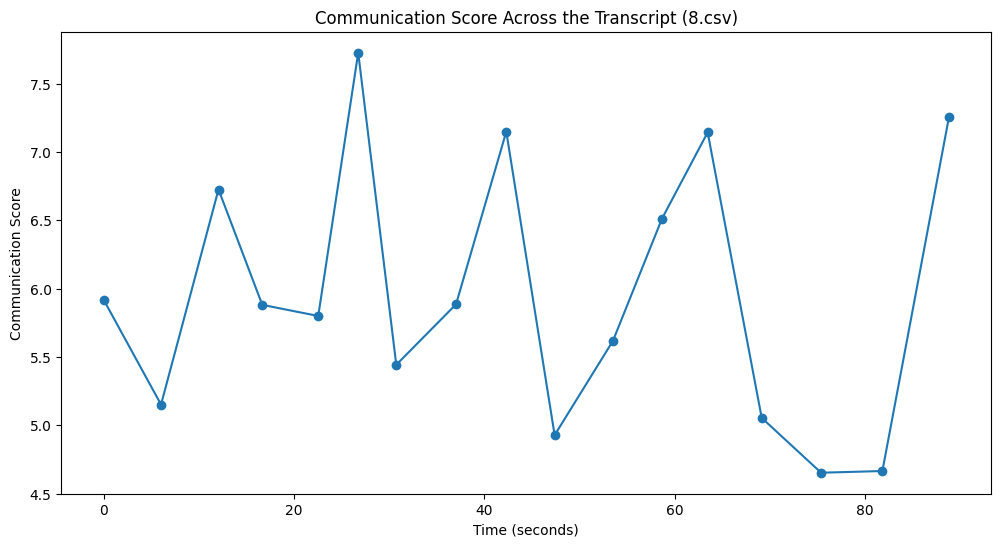

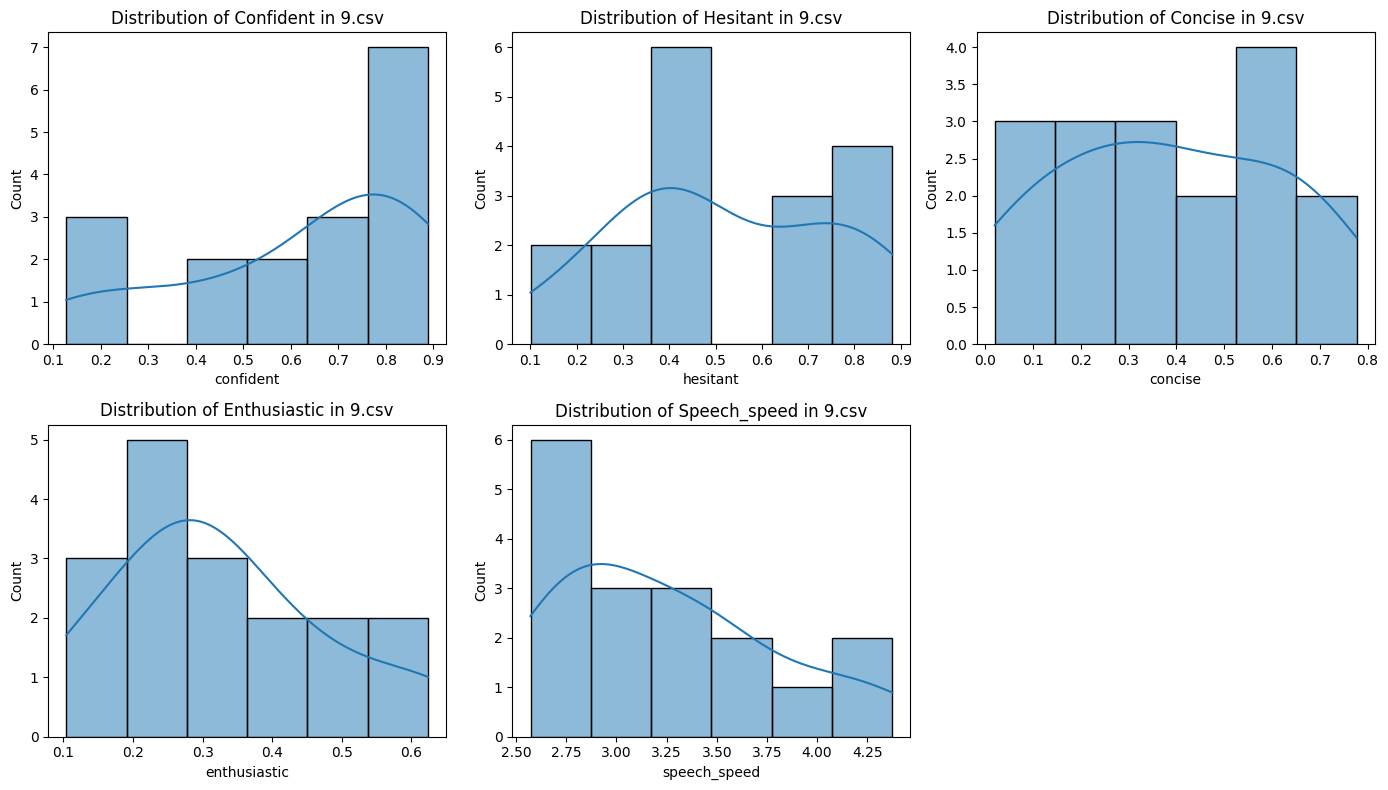

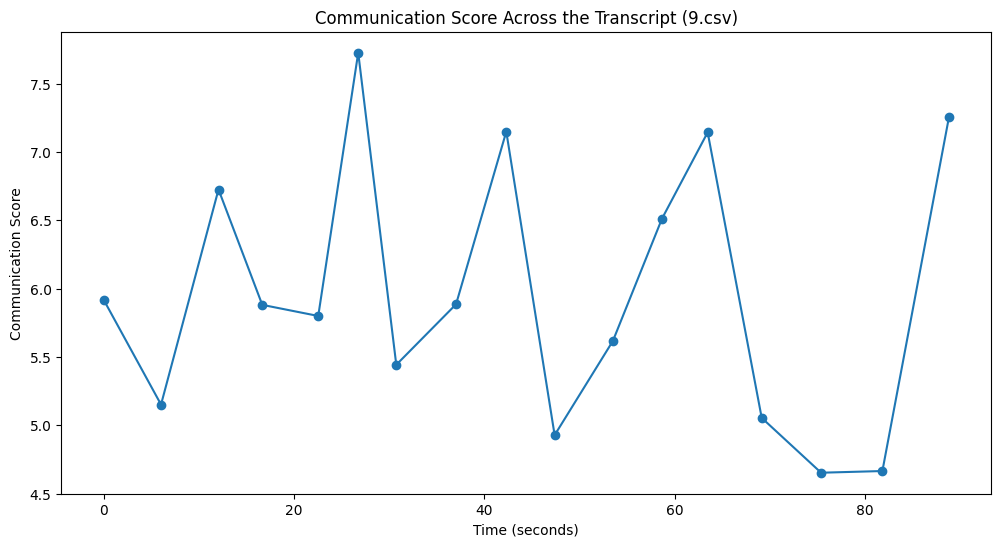

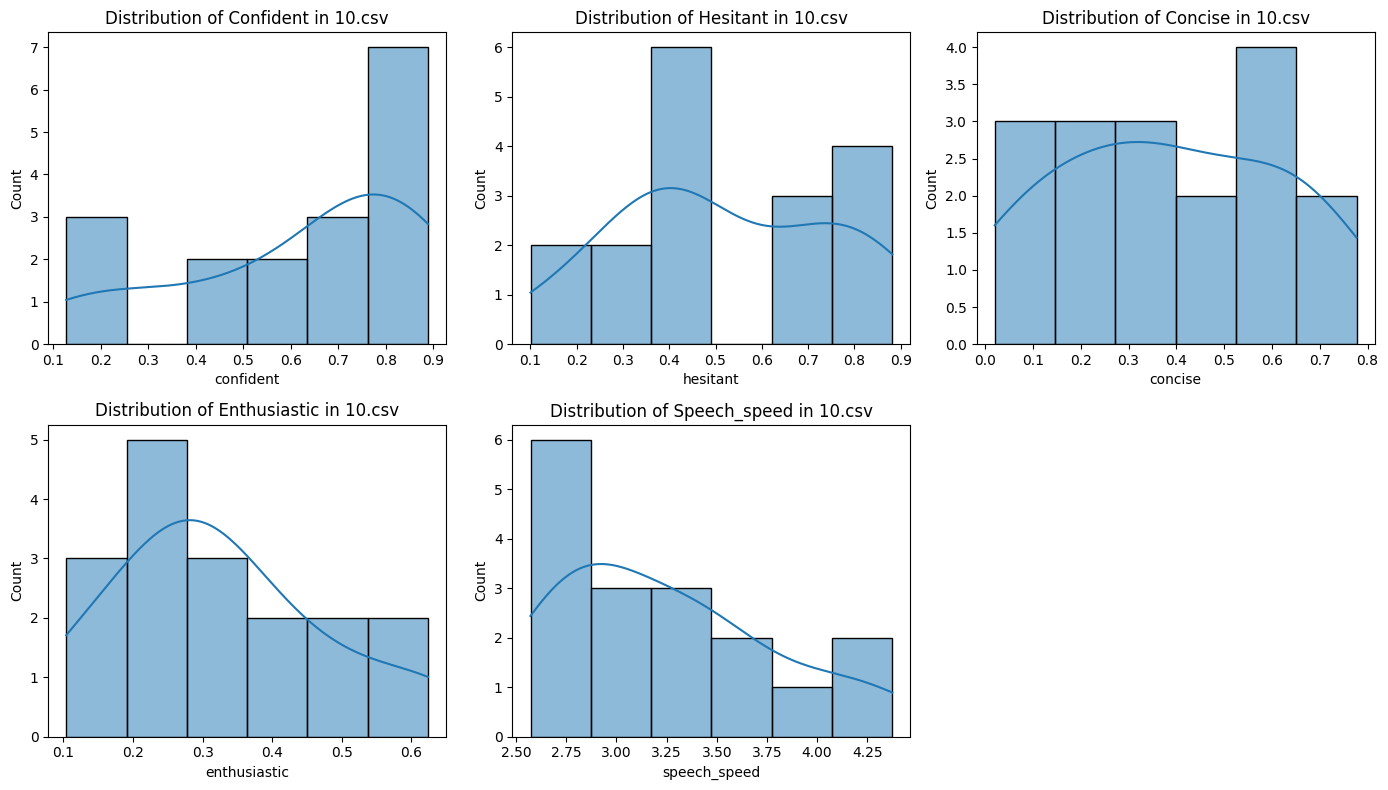

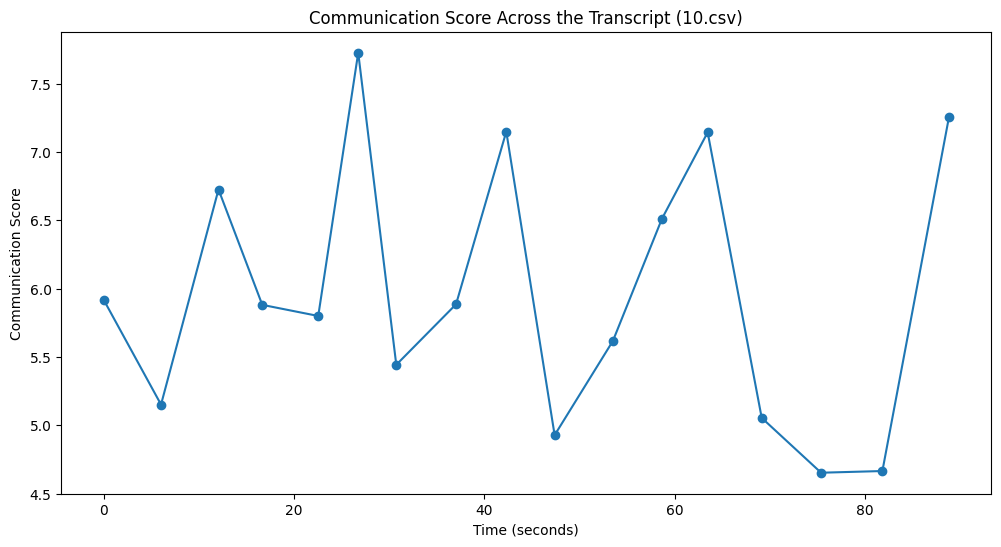

In [ ]:
# Analyze and plot distributions in the transcript data
for candidate_number in range(1, 11):
    features = ['confident', 'hesitant', 'concise', 'enthusiastic', 'speech_speed']

    plt.figure(figsize=(14, 8))
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i+1)
        sns.histplot(transcript_data[feature], kde=True)
        plt.title(f'Distribution of {feature.capitalize()} in {candidate_number}.csv')
    plt.tight_layout()
    plt.show()

    # Generate communication score
    transcript_data['communication_score'] = (
        transcript_data['confident'] * 2
        - transcript_data['hesitant'] * 1.5
        + transcript_data['concise'] * 1.2
        + transcript_data['enthusiastic'] * 1.5
        + transcript_data['speech_speed'] * 1.0
        - transcript_data['avg_logprob'] * 0.5
        + transcript_data['compression_ratio'] * 1.0
        - transcript_data['no_speech_prob'] * 2.0
    )

    # Plot the communication score across the transcript
    plt.figure(figsize=(12, 6))
    plt.plot(transcript_data['start'], transcript_data['communication_score'], marker='o')
    plt.title(f'Communication Score Across the Transcript ({candidate_number}.csv)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Communication Score')
    plt.show()


In [ ]:

print(merged_data.columns)

Index(['movie_id', 'image_seq', 'angry', 'disgust', 'fear', 'happy', 'sad',
       'surprise', 'neutral', 'dominant_emotion', 'gaze', 'blink',
       'eye_offset', 'participant_id', 'elapsed_time', 'upload_time',
       'distance', 'candidate_id'],
      dtype='object')


In [ ]:
# Calculate the communication_score based on relevant features
transcript_data['communication_score'] = (
    transcript_data['confident'] * 2
    - transcript_data['hesitant'] * 1.5
    + transcript_data['concise'] * 1.2
    + transcript_data['enthusiastic'] * 1.5
    + transcript_data['speech_speed'] * 1.0
    - transcript_data['avg_logprob'] * 0.5
    + transcript_data['compression_ratio'] * 1.0
    - transcript_data['no_speech_prob'] * 2.0
)


In [ ]:
# Assuming 'eyeoffset' and 'blink' are available in the emotion_data
merged_data['focus_score'] = (
    - merged_data['eye_offset'] * 2   # Penalizing higher eyeoffset (less focus)
    + merged_data['blink'] * 1.0     # Blink contributes positively to focus
)


In [ ]:
# Print columns to ensure candidate_id exists
print("Transcript Data Columns: ", transcript_data.columns)
print("Merged Data Columns: ", merged_data.columns)

# If 'candidate_id' is named differently, rename it in both dataframes
if 'candidate_id' not in transcript_data.columns:
    transcript_data.rename(columns={'your_column_name': 'candidate_id'}, inplace=True)

if 'candidate_id' not in merged_data.columns:
    merged_data.rename(columns={'your_column_name': 'candidate_id'}, inplace=True)

# Now proceed with the merge after checking the column
merged_data_2 = pd.merge(transcript_data[['candidate_id', 'communication_score']],
                         merged_data[['candidate_id', 'focus_score']],
                         on='candidate_id')


Transcript Data Columns:  Index(['id', 'seek', 'start', 'end', 'text', 'tokens', 'temperature',
       'avg_logprob', 'compression_ratio', 'no_speech_prob', 'positive',
       'negative', 'neutral', 'confident', 'hesitant', 'concise',
       'enthusiastic', 'speech_speed', 'candidate_id', 'Hirability_score',
       'communication_score'],
      dtype='object')
Merged Data Columns:  Index(['movie_id', 'image_seq', 'angry', 'disgust', 'fear', 'happy', 'sad',
       'surprise', 'neutral', 'dominant_emotion', 'gaze', 'blink',
       'eye_offset', 'participant_id', 'elapsed_time', 'upload_time',
       'distance', 'candidate_id', 'focus_score'],
      dtype='object')


In [ ]:
# Calculate the Hirability score by combining different elements, focusing on both communication and focus
merged_data_2['hirability_score'] = (
    merged_data_2['communication_score'] * 2
    + merged_data_2['focus_score'] * 1.5   # You can adjust the weights as needed
)


In [ ]:
merged_data_2['candidate_id'] = merged_data_2['candidate_id'].astype(str)


In [ ]:
# Define a threshold for hiring decision
threshold = 5.0

# Create a final column to decide if the candidate is a good fit based on their scores
merged_data_2['hire_decision'] = merged_data_2['hirability_score'] >= threshold

# View the results
print(merged_data_2[['candidate_id', 'communication_score', 'focus_score', 'hirability_score', 'hire_decision']])


     candidate_id  communication_score  focus_score  hirability_score  \
0              10             5.919779      -9.6198         -2.590143   
1              10             5.919779     -94.1314       -129.357543   
2              10             5.919779       2.4324         15.488157   
3              10             5.919779      -1.2742          9.928257   
4              10             5.919779      -2.5806          7.968657   
...           ...                  ...          ...               ...   
1491           10             7.255699      49.9392         89.420198   
1492           10             7.255699     -81.1600       -107.228602   
1493           10             7.255699      23.2994         49.460498   
1494           10             7.255699     -16.2438         -9.854302   
1495           10             7.255699      -7.4918          3.273698   

      hire_decision  
0             False  
1             False  
2              True  
3              True  
4            

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 100))
merged_data_2['hirability_score_normalized'] = scaler.fit_transform(merged_data_2[['hirability_score']])


In [ ]:
import openai
print(openai.__version__)

1.43.0


In [ ]:
# Initialize the OpenAI client
client = OpenAI(api_key='sk-qWN-nEM2ZjKzKJVpqBxJbqR0vK9PELl32Ne3qYr4uNT3BlbkFJET7JmCA8fZ4VD1X8GKERNJUMEV3O61iDHqu0BmrTEA')

# Iterate through each candidate's data
for candidate_number in range(1, 11):
    # Load the entire transcript text
    transcript_file = os.path.join(transcript_scores_dir, f'{candidate_number}.csv')
    with open(transcript_file, 'r') as file:
        transcript_text = file.read()

    # Load the transcript scores data
    transcript_score_file = os.path.join(transcript_scores_dir, f'{candidate_number}.csv')
    transcript_data = pd.read_csv(transcript_score_file)  # Fixed variable name

    # Ensure 'communication_score' and 'hirability_score' are calculated
    if 'communication_score' not in transcript_data.columns:
        transcript_data['communication_score'] = (
            transcript_data['confident'] * 2
            - transcript_data['hesitant'] * 1.5
            + transcript_data['concise'] * 1.2
            + transcript_data['enthusiastic'] * 1.5
            + transcript_data['speech_speed'] * 1.0
            - transcript_data['avg_logprob'] * 0.5
            + transcript_data['compression_ratio'] * 1.0
            - transcript_data['no_speech_prob'] * 2.0
        )

    if 'hirability_score' not in transcript_data.columns:
        transcript_data['hirability_score'] = (
            transcript_data['confident'] * 2
            - transcript_data['hesitant'] * 1.5
            + transcript_data['concise'] * 1.2
            + transcript_data['enthusiastic'] * 1.5
            + transcript_data['speech_speed'] * 1.0
        )

    # Load the emotion, gaze, and metadata files for the candidate
    folder_path = os.path.join(emotion_data_base_dir, str(candidate_number))
    emotion_file = os.path.join(folder_path, 'emotion.csv')
    gaze_file = os.path.join(folder_path, 'gaze.csv')
    metadata_file = os.path.join(folder_path, 'metadata.csv')

    emotion_data = pd.read_csv(emotion_file)
    gaze_data = pd.read_csv(gaze_file)
    metadata = pd.read_csv(metadata_file)

    # Merge emotion data with gaze data on common columns
    merged_data_1 = pd.merge(emotion_data, gaze_data, on=['movie_id', 'image_seq'])

    # Merge the above result with metadata on common columns
    final_merged_data = pd.merge(merged_data_1, metadata, on=['movie_id', 'image_seq'])

    # Fix the percentage issue by calculating the percentage of each emotion properly
    total_emotions = len(final_merged_data)
    avg_emotions = final_merged_data[['happy', 'sad', 'neutral']].mean()
    emotion_summary = (
        f"Average Emotions: {(avg_emotions['happy'])*100:.1f}% happy, "
        f"{(avg_emotions['sad'])*100:.1f}% sad, "
        f"{(avg_emotions['neutral'])*100:.1f}% neutral."
    )

    # Summarize the gaze data for the entire transcript
    avg_gaze = final_merged_data[['gaze', 'blink']].mean()
    gaze_summary = f"Average Gaze: {avg_gaze['gaze']:.2f}, Average Blink: {avg_gaze['blink']:.2f}."

    # Summarize the transcript data
    avg_confidence = transcript_data['confident'].mean()
    avg_hesitant = transcript_data['hesitant'].mean()
    avg_concise = transcript_data['concise'].mean()
    avg_enthusiastic = transcript_data['enthusiastic'].mean()
    avg_speech_speed = transcript_data['speech_speed'].mean()

    transcript_summary = (
        f"Transcript Summary: Average Confidence: {avg_confidence:.2f}, "
        f"Average Hesitant: {avg_hesitant:.2f}, "
        f"Average Concise: {avg_concise:.2f}, "
        f"Average Enthusiasm: {avg_enthusiastic:.2f}, "
        f"Average Speech Speed: {avg_speech_speed:.2f}."
    )

    # Add the calculated scores for communication, hirability, and focus
    communication_score = transcript_data['communication_score'].mean()
    hirability_score = transcript_data['hirability_score'].mean()

    # Check if 'focus_score' exists, calculate it otherwise
    if 'focus_score' not in emotion_data.columns:
        merged_data_1['focus_score'] = (
            - merged_data_1['eye_offset'] * 2   # Penalizing higher eyeoffset (i.e., less focus)
            + merged_data_1['blink'] * 1.0     # Blinking is normal, so assigning a small positive weight
        )
    focus_score = merged_data_1['focus_score'].mean()

    score_summary = (
        f"Scores: Communication Score: {communication_score:.2f}, "
        f"Hirability Score: {hirability_score:.2f}, "
        f"Focus Score: {focus_score:.2f}."
    )

    # Create the prompt with the newly added scores
    prompt = f"""
    Analyze the candidate's overall performance based on the transcript from their introductory video, the summarized emotional and gaze behavior data, and the calculated scores.

    Transcript:
    {transcript_text[:2000]}  # Displaying only the first 2000 characters for brevity

    {transcript_summary}

    Emotion Summary:
    {emotion_summary}

    Gaze Summary:
    {gaze_summary}

    {score_summary}

    Please identify the candidate's key strengths and whether they are suitable for recruitment based on the provided data.
    """

    # Create a chat completion using the new API
    chat_completion = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are an HR assistant whose job is to identify a candidate's key strengths based on the input provided."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=1000,
        temperature=0.7,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )

    # Print the response from ChatGPT
    print(f"ChatGPT Response for Candidate {candidate_number}:\n", chat_completion.choices[0].message.content.strip())
    print("\n" + "="*50 + "\n")


ChatGPT Response for Candidate 1:
 Based on the provided data, the candidate, Jeffrey Shepherd, possesses several key strengths:

1. Strong Educational Background: Jeffrey has a solid educational background with a B.Tech in Biotechnology followed by an M.Tech from IIT Kharagpur. He is currently pursuing postgraduate studies in management from IIM Coikode. This indicates a high level of commitment to education and a solid foundation in his field.

2. Relevant Experience: Jeffrey has three years of experience in the regulatory affairs domain of the pharmaceutical industry. This indicates he has practical knowledge and experience in his field.

3. Good Communication Skills: With an average communication score of 5.39, it is clear that Jeffrey is a competent communicator. He speaks with confidence (average confidence: 0.73) and is not overly hesitant (average hesitant: 0.49).

4. Emotional Stability: The emotion summary shows that Jeffrey was predominantly neutral (5011.1%) during his pres